In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import numpy as np
import glob
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz
from astropy.time import Time
from astropy.table import Table
from lstchain.reco.utils import location, add_delta_t_key
from os import path
from lstchain.reco.utils import  get_effective_time
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from pyirf.spectral import CRAB_MAGIC_JHEAP2015, PowerLaw
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from ctapipe.io import read_table

import tables

from ctapipe.image.hillas import camera_to_shower_coordinates

%matplotlib inline

In [2]:
plt.style.use('seaborn-paper')
plt.style.use('seaborn-colorblind')

/tmp/ipykernel_24908/1160103147.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')
/tmp/ipykernel_24908/1160103147.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [3]:
good_runs = []
# If good_runs is defined, only runs in the list will be used 

# good_runs = [2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977] # only 20201120 night, for test

# Full starting sample:
good_runs = [2913, 2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2952, 2953,
             2954, 2955, 2956, 2957, 2958, 2967, 2968, 2969, 2970, 2971, 2972, 2973,
             2974, 2975, 2976, 2977, 2988, 2989, 2990, 2991, 2992, 3004, 3005, 3006,
             3007, 3008, 3093, 3094, 3095, 3096, 3231, 3232, 3243, 3270, 3271, 3272,
             3273, 3274, 3275, 3276, 3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328,
             3329, 3330, 3338, 3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601,
             3615, 3631, 3632, 3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677,
             3678, 3679, 3706, 3707, 3708, 3954, 3955, 3956, 3973, 3974, 3975, 4027,
             4028, 4029, 4067, 4068, 4086, 4087, 6045, 6073, 6148, 6193, 6194, 6195,
             6242, 6281, 6282, 6303, 6304, 6324, 6872, 6873, 6874, 6875, 6892, 6893,
             6894, 6895, 7086, 7097, 7098, 7099, 7133, 7136, 7161, 7195, 7196, 7197,
             7198, 7199, 7200, 7227, 7228, 7231, 7232, 7233, 7253, 7254, 7255, 7256,
             7274, 7275, 7276, 7277]


# The list of runs below is the sample with the q>30_rate and q>10_rate cuts applied:
#
#good_runs = [2913, 2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2955, 2967,
#             2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
#             2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095, 3096,
#             3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278,
#             3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338, 3339, 3340, 3355,
#             3356, 3373, 3598, 3599, 3600, 3601, 3615, 3632, 3633, 3634, 3635, 3672,
#             3673, 3674, 3675, 3676, 3677, 3706, 3707, 3708, 3954, 3955, 3974, 4027,
#             4067, 4068, 4086, 4087, 6045, 6073, 6148, 6195, 6304, 6872, 6873, 6874,
#             6875, 6892, 6893, 6894, 6895, 7086, 7097, 7098, 7099, 7133, 7136, 7161,
#             7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231, 7232, 7233, 7253, 7254,
#             7255, 7256, 7274, 7275, 7276, 7277]


In [4]:
# NOTE:
# The DL2 files finally used in the performance paper were produced only for the 117 runs which survived all 
# quality cuts, among which the cut in R_80-120 that is computed here!
# Hence we are using here a previous version of the DL2 files (a version in which we also have the *bad* runs):
dataset1 = glob.glob("/fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2*h5")
dataset1.sort()

# It is not relevant because the relevant quantity (intensity) is computed at the DL1 level and hence it is 
# identical in any DL2 file produced from the DL1 files. The only DL2 parameter we use is gammaness, and only for 
# a very soft cut, in order to get rid of very bright fake events, like car flashes or shots of the MAGIC LIDAR.


In [5]:
total_n_files = len(dataset1)

selected_files = []

for file in dataset1:
    ii = file.find("LST-1.Run")
    run = int(file[ii+9:ii+14])
    if (len(good_runs) > 0) and (run not in good_runs):
        continue
    selected_files.append(file)

    
dataset1 = selected_files

if len(good_runs) > 0:
    print ('Found', len(selected_files), 'of the', len(good_runs), 'desired runs among the',
           total_n_files, 'available files')
else:
    print ('Found', len(selected_files), 'files')


Found 148 of the 148 desired runs among the 196 available files


In [6]:
print(len(dataset1))

148


In [7]:
columns = ['obs_id', 'event_id', 'log_intensity', 'x', 'y',
           # 'n_pixels', 'concentration_core', 'concentration_pixel', 'n_islands', 
           'alt_tel', 'az_tel', 'dragon_time',
           'event_type', 'delta_t',
           'log_reco_energy',
           'reco_src_x', 'reco_src_y',
           'gammaness', 'src_x', 'src_y', 
           #'brightest_pixel'
          ]

tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
dummy = []

eff_time_per_run = []
elapsed_time_per_run = []
run_number = []

livetime = 0


for irun, file in enumerate(dataset1):
    print(irun, ":", file)
    tb = pd.read_hdf(file, tablename)
    lt, et = get_effective_time(tb)
    livetime += lt
    
    run_number.append(tb['obs_id'][0])
    eff_time_per_run.append(lt.to(u.s).value)
    elapsed_time_per_run.append(et.to(u.s).value)
    
    # Add source_position info:
    tb2 = pd.read_hdf(file, "source_position")
    for var in tb2:
        tb[var] = tb2[var]
    
    for colname in tb.columns:
        if colname == 'dragon_time':
            continue
        if colname == 'delta_t':
            continue
        if tb[colname].dtype != 'float64':
            continue
        tb[colname] = tb[colname].astype('float32')  # save some memory!
    
    dummy.append(tb[columns])

0 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run02913.h5
1 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run02914.h5
2 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run02929.h5
3 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run02930.h5
4 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run02931.h5
5 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run02932.h5
6 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run02933.h5
7 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_on

63 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run03339.h5
64 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run03340.h5
65 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run03355.h5
66 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run03356.h5
67 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run03373.h5
68 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run03598.h5
69 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run03599.h5
70 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sampl

126 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run07133.h5
127 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run07136.h5
128 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run07161.h5
129 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run07195.h5
130 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run07196.h5
131 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run07197.h5
132 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/full_sample/DL2_onlynsb_standard_RF/dl2_LST-1.Run07198.h5
133 : /fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/fu

In [8]:
len(tb)

4199430

In [9]:
table1 = pd.DataFrame()
# A bit of a cumbersome way of building the whole table, because otherwise the coexistence of the "dummy" list
# and the dataframe takes too much memory for long datasamples!

while len(dummy) > 0:
    print(len(dummy))
    tmpdf = pd.concat(dummy[:10])
    dummy = dummy[10:] # remove what has just been added to table1
    table1 = pd.concat([table1, tmpdf])

# table1 = pd.concat(dummy[:100], ignore_index=True)
print("Live time:", livetime.to(u.h))

eff_time_per_run = np.array(eff_time_per_run)
elapsed_time_per_run = np.array(elapsed_time_per_run)

run_number = np.array(run_number)
print(eff_time_per_run)
print(run_number)

148
138
128
118
108
98
88
78
68
58
48
38
28
18
8
Live time: 42.635051865925554 h
[1133.46209259 1110.75562327 1006.04501465 1107.19235931 1097.38703758
 1096.5269345  1109.3749366  1109.3351765  1143.83952575 1166.21326655
 1120.58727347 1131.13751971 1123.82532072 1113.64183995 1090.08045143
 1150.55666906  835.44097587 1149.93783483 1134.18440588 1132.29115388
 1129.30234595 1137.18786918 1131.1962079  1131.05147585 1137.84540527
 1135.30702151 1109.60115868 1125.97946755 1113.5734674  1112.76803359
 1105.23285427 1130.22345404 1138.25388294 1113.59934067 1099.88396142
 1093.7606981  1127.1305846  1119.00794828 1117.07188434 1167.0822392
 1839.57656366 1159.52571339 1145.79956547 1167.39177729 1137.02006105
 1132.7112623  1128.20644252 1132.02226422 1156.40116734 1121.10203321
 1182.23144574 1154.56723717 1139.9904119  1145.51335282  854.7822538
 1090.73196827 1154.12699569 1117.55864263 1146.6971091  1140.89011039
 1135.01457748 1138.42849452 1199.69992026 1105.5803467  1025.7525635

In [10]:
teff = livetime.to(u.s).value
print(teff/3600, "h")

42.635051865925554 h


In [11]:
table1.columns

Index(['obs_id', 'event_id', 'log_intensity', 'x', 'y', 'alt_tel', 'az_tel',
       'dragon_time', 'event_type', 'delta_t', 'log_reco_energy', 'reco_src_x',
       'reco_src_y', 'gammaness', 'src_x', 'src_y'],
      dtype='object')

In [12]:
cosmics1 = (table1['event_type']==32)

In [13]:
def find50(curve):
    max = curve.y.max()
    x50 = 0
    for x in np.linspace(curve.x.min(), curve.x.max(), 10000):
        if curve(x) > 0.5*max:
            x50 = x
            break
    return x50

In [14]:
# Create an index (from 0 to nruns -1) just indicating for each event the run to which it belongs
# This is useful to make 2d histograms in which one axis indicates the run; if we use the actual run number the
# histograms would be sparsely filled

obs_id = table1['obs_id'].to_numpy()
run_changes = np.where(obs_id[1:] != obs_id[:-1])[0] + 1
run_changes = np.append(run_changes, len(table1))
run_changes = np.concatenate(([0], run_changes))
run_order = np.zeros_like(obs_id)
print(run_changes)
k = 0
for n1, n2 in zip(run_changes[:-1], run_changes[1:]):
    run_order[n1:n2] = k
    k += 1

print()
print(run_order[0], run_order[-1], len(run_order), len(table1))

[        0   4592792   9460180  14290877  19468037  24613269  29625046
  34772836  39880590  44790257  50670235  54747349  58479777  62788231
  67877687  72590801  75712407  78917574  83940304  89093623  94358893
  99740347 105243916 110795060 116345807 121928803 127408658 132685495
 137947372 143726755 149269243 154690216 160106268 165451193 171188914
 176516337 181998668 187609628 193070257 198394027 204050686 213012352
 218822381 223432840 227816075 232322517 237316096 242363816 247460660
 252691815 257706404 262657293 267427762 272036214 276576651 279851659
 284315205 289059444 293661667 298398080 303101352 307647386 312130338
 317037862 321479126 325560411 330223481 334892707 339695665 344020735
 348499368 353082362 357113476 363020995 365219704 369302750 371626816
 375638845 379257534 383440121 387925436 392235626 396088184 400179275
 404407505 408548983 412588398 416957882 421170241 425688863 430590993
 434472035 437888677 440054947 444431637 448202327 452615761 455722964
 45929

In [15]:
cosmics_per_run, _ = np.histogram(run_order[cosmics1], 
                                  bins=1+run_order.max(), range=(-0.5, run_order.max()))


cosmics_per_run_igt100, _ = np.histogram(run_order[cosmics1 & (table1['log_intensity']>2)], 
                                         bins=1+run_order.max(), range=(-0.5, run_order.max()))


cosmics_per_run_i80to120, _ = np.histogram(run_order[cosmics1 & 
                                                      (table1['log_intensity']>1.903) &
                                                      (table1['log_intensity']<2.079)], 
                                            bins=1+run_order.max(), range=(-0.5, run_order.max()))


cosmics_per_run_i280to320, _ = np.histogram(run_order[cosmics1 & 
                                                      (table1['log_intensity']>2.447) &
                                                      (table1['log_intensity']<2.505)], 
                                            bins=1+run_order.max(), range=(-0.5, run_order.max()))

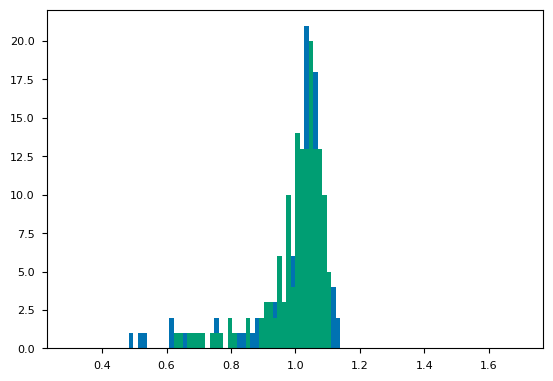

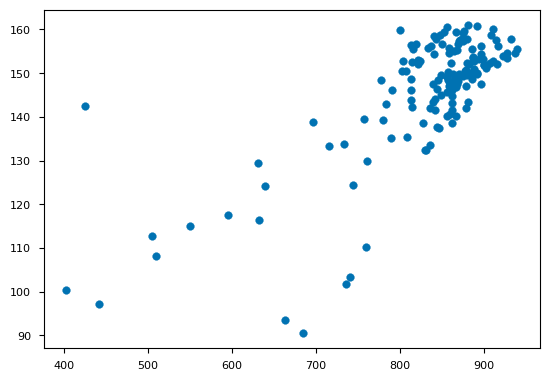

In [16]:
rate_80_120 = cosmics_per_run_i80to120/eff_time_per_run
plt.hist(rate_80_120/rate_80_120.mean(), bins=100, range=(0.3,1.7))
rate_280_320 = cosmics_per_run_i280to320/eff_time_per_run
plt.hist(rate_280_320/rate_280_320.mean(), bins=100, range=(0.3,1.7))
plt.show()

plt.scatter(rate_80_120, rate_280_320)
plt.show()

In [17]:
# The soft gammaness cut is to remove some spurious bright events (from e.g. misidentified calibrations, 
# or car flashes) which may be present in otherwise perfectly usable runs
soft_gammaness_cut = table1['gammaness'] > 0.05
# soft_gammaness_cut = table1['gammaness'] > -1  # TEST

In [18]:
cosmics_per_run_igt100_soft_gcut, _ = np.histogram(run_order[cosmics1 & (table1['log_intensity']>2) & 
                                                             soft_gammaness_cut], 
                                                   bins=1+run_order.max(), range=(-0.5, run_order.max()))

In [19]:
alt, _ = np.histogram(run_order[cosmics1],
                      weights=table1['alt_tel'][cosmics1],  
                      bins=1+run_order.max(), range=(-0.5, run_order.max()))

zenith = 90 - np.rad2deg(alt / cosmics_per_run)
zenith

array([ 9.87781107, 14.82801736, 15.85635039, 11.24155678,  7.9709226 ,
        7.15564841,  8.3740302 , 12.73625869, 19.94779638, 13.98593657,
        6.71075203,  9.82661713, 12.98322411, 18.05472186, 21.60589719,
       26.62539756, 30.27794419, 29.74034616, 24.64949928, 20.58142483,
       15.80907425, 11.97796713,  8.45676343,  6.65066164,  8.5514712 ,
       11.09365015, 15.93152179, 19.52146629,  6.73574548,  8.33381116,
       10.83013813, 15.61837641, 19.22541752,  9.7786412 , 14.42043863,
       18.15085538, 23.38393853, 27.28292668, 26.66856712, 21.55822095,
       15.96024693,  9.96920909, 25.91618494, 31.54339959, 27.72213704,
       28.62268071, 24.52786408, 19.63103903, 15.65872818, 11.29999472,
        7.54353258,  7.35127333,  9.10161876, 13.64410242, 16.57803977,
       14.77597268, 10.65119145,  7.71734606,  7.19496272,  9.5601507 ,
       14.11220362, 17.52317564,  6.6661081 ,  8.63748089, 10.95841777,
        7.86296354, 11.93064262, 24.47559503, 14.03467563, 19.16

In [20]:
cosaz, _ = np.histogram(run_order[cosmics1],
                        weights=np.cos(table1['az_tel'][cosmics1]),  
                        bins=1+run_order.max(), range=(-0.5, run_order.max()))
sinaz, _ = np.histogram(run_order[cosmics1],
                        weights=np.sin(table1['az_tel'][cosmics1]),  
                        bins=1+run_order.max(), range=(-0.5, run_order.max()))

azimuth = np.rad2deg(np.arctan2(sinaz / cosmics_per_run, 
                                cosaz / cosmics_per_run))
azimuth[azimuth<0] += 360
print(azimuth)

zenith = 90 - np.rad2deg(alt / cosmics_per_run)
print(zenith)

[230.00602711 245.10417061 110.6881226  126.54464637 144.97208998
 188.4672543  219.14407515 239.21410507 104.3126437  117.07056639
 189.78207328 225.83831935 242.49381761 251.41343201 257.67555079
 261.36600726 265.22010738  95.17001411 100.43381389 103.52326959
 112.72249581 120.72952219 145.53344276 175.33497884 215.46880617
 235.89010373 247.5381725  255.13403959 169.49285477 213.11554041
 234.77484665 246.87221342 254.73459827 229.45994416 244.10462297
 253.20648408 258.29732122 262.98546786  97.51323946 103.74136731
 110.77379958 133.26785684 261.86081252 265.14103269 263.3298471
  96.99949166  99.36734569 106.2174389  111.10646911 126.26160593
 150.64838817 196.11901001 225.09162897 242.00184048 250.6878239
 112.94034423 129.38658903 147.99970538 190.6088246  228.12349923
 243.29071574 252.22534187 175.08193532 216.44766413 235.41871201
 213.75863186 236.31441116 260.58191362 245.33499956 253.11701288
 259.17415894 263.25011579 260.92822029 241.24532042 249.72600557
 256.9758188

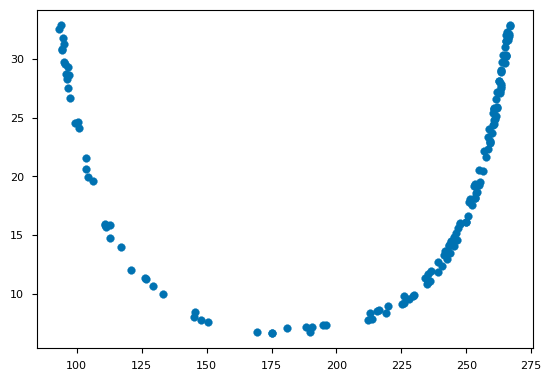

In [21]:
plt.scatter(azimuth, zenith)
plt.show()

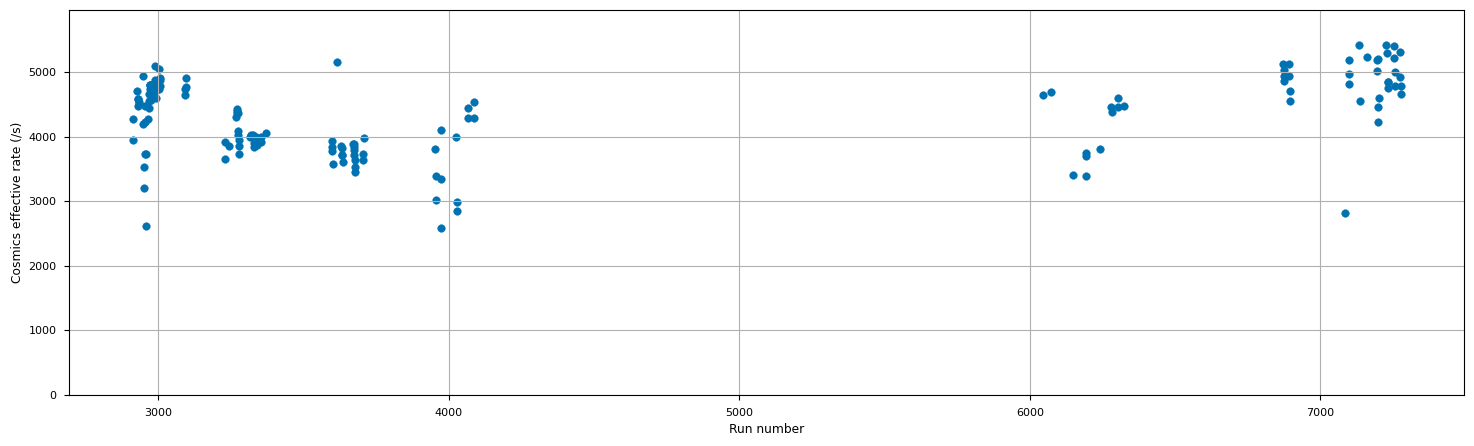

In [22]:
plt.figure(figsize=(18,5))
plt.scatter(run_number, cosmics_per_run/eff_time_per_run)
plt.ylim(0, 1.1*np.max(cosmics_per_run / eff_time_per_run))
plt.grid()
plt.ylabel('Cosmics effective rate (/s)')
plt.xlabel('Run number')
plt.show()

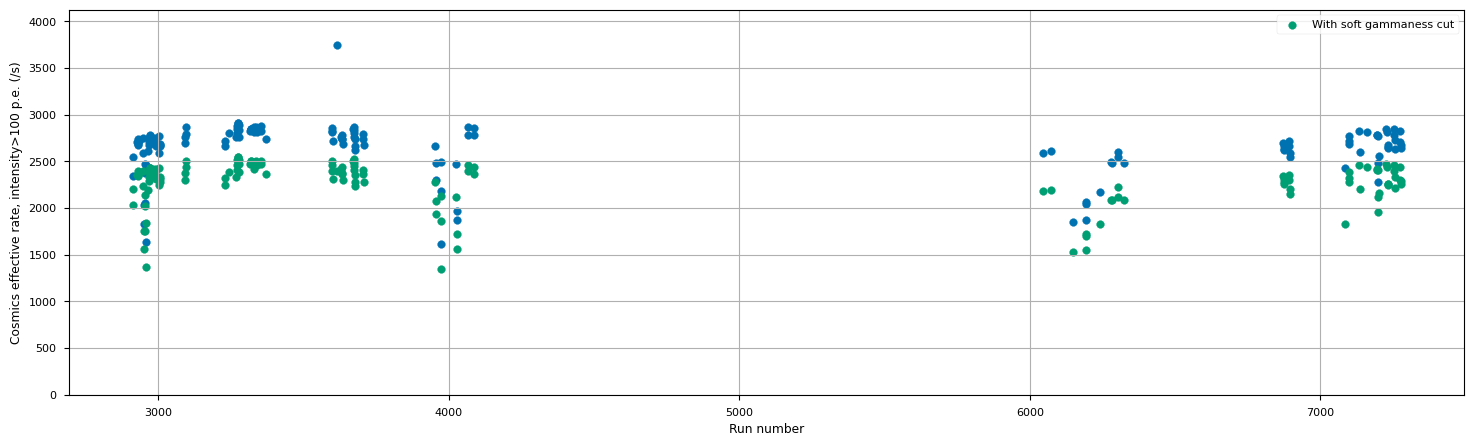

In [23]:
plt.figure(figsize=(18,5))
plt.scatter(run_number, cosmics_per_run_igt100 / eff_time_per_run)
plt.scatter(run_number, cosmics_per_run_igt100_soft_gcut / eff_time_per_run, label='With soft gammaness cut')

plt.ylim(0, 1.1*np.max(cosmics_per_run_igt100 / eff_time_per_run))
plt.grid()
plt.ylabel('Cosmics effective rate, intensity>100 p.e. (/s)')
plt.xlabel('Run number')
plt.legend()
plt.show()

In [24]:
# gap in event id. Positive gap > 1 means event is missing in DL2 just because it did not survive cleaning
d_id = np.diff(table1['event_id'])

mask = (d_id > 1)
# add up all the missing events per run:
missing_evts, _ = np.histogram(run_order[1:][mask], weights=d_id[mask]-1, bins=(1+run_order.max()), range=(-0.5, run_order.max()+0.5))

In [25]:
# interleaved FF events: all of them must have passed the cleaning so should be there:
ff_evts, _ = np.histogram(run_order[table1['event_type']==0], bins=(1+run_order.max()), range=(-0.5, run_order.max()+0.5))

In [26]:
ff_rate = ff_evts/eff_time_per_run
print(np.mean(ff_rate[ff_rate>0]))

99.70868976004849


In [27]:
# Some of the missing ones are interleaved pedestals (event_type 2). We assume their rate (before dead time) is 100 Hz
ped_evts, _ = np.histogram(run_order[table1['event_type']==2], bins=(1+run_order.max()), range=(-0.5, run_order.max()+0.5))

missing_ped_evts = 100*eff_time_per_run - ped_evts

In [28]:
# plt.figure(figsize=(15,4))
# plt.scatter(run_number, ff_evts/eff_time_per_run, s=6)
# plt.grid()
# plt.show()
# run_number[np.where(ff_evts/eff_time_per_run<5)[0][0]]

In [29]:
# plt.figure(figsize=(18,5))
# plt.scatter(run_number, missing_evts/eff_time_per_run)
# plt.ylabel('Rate of events missing in DL2 (/s)')
# plt.xlabel('Run number')
# plt.grid()
# plt.show()

In [30]:
# We add up the number of cosmics in the DL2 files with the number of missing events (triggers killed in cleaning stage):
triggered_cosmics_per_run = cosmics_per_run + missing_evts - missing_ped_evts

In [31]:
trigger_info = read_table('/fefs/aswg/workspace/abelardo.moralejo/2022_MC_production/Crab_test/trigger_info/camera_hdf_merged.h5', '/camera/parameters')

print(trigger_info.columns)

l1_dt_mean = []
l1_dt_std = []

run_id = trigger_info['run_id']

for run in run_number:
    if run not in run_id:
        l1_dt_mean.append(np.nan)
        l1_dt_std.append(np.nan)
        continue
    
    index = np.where(run_id == run)[0][0]
    l1_dt_mean.append(trigger_info['l1_dt_a_mean'][index])
    l1_dt_std.append(trigger_info['l1_dt_a_std'][index])

l1_dt_mean = np.array(l1_dt_mean)
l1_dt_std = np.array(l1_dt_std)

<TableColumns names=('run_id','dragon_time','l1_dt_a_mean','l1_dt_a_std','l1_dt_b_mean','l1_dt_b_std','an_cur_mean','an_cur_std')>


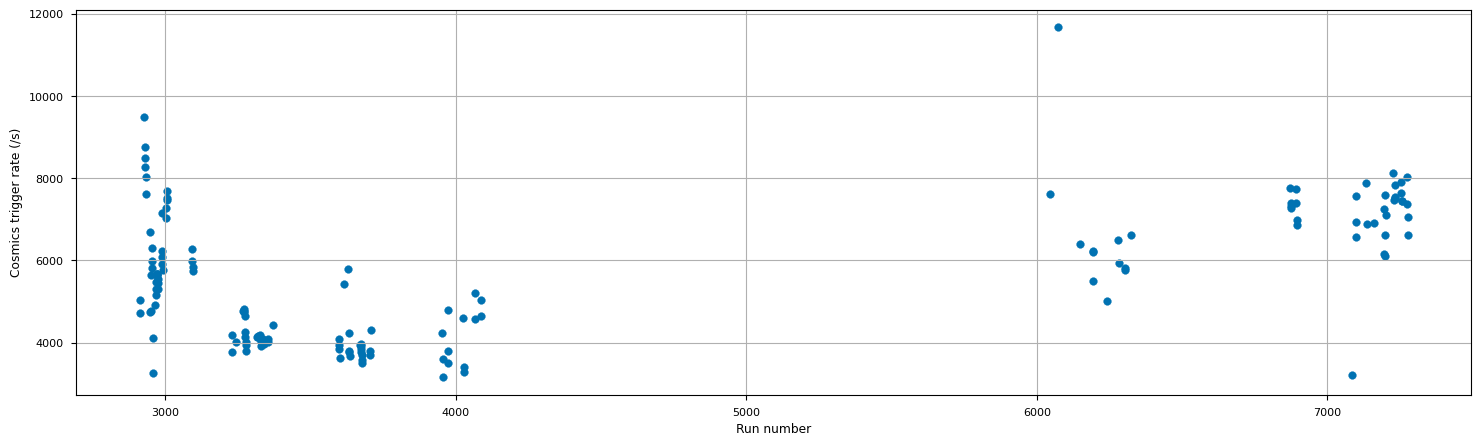

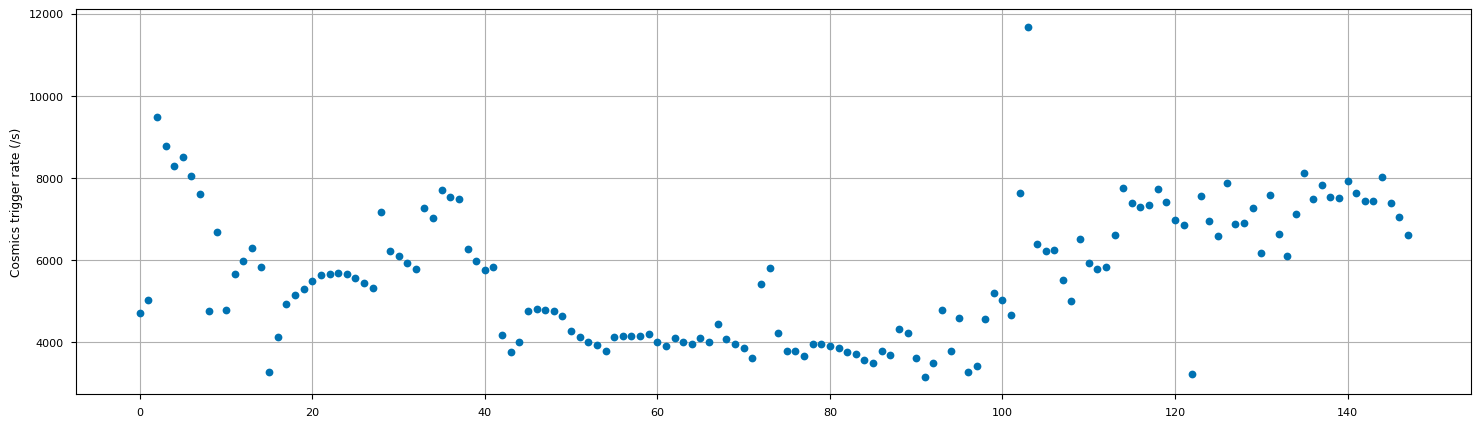

In [32]:
plt.figure(figsize=(18,5))
plt.scatter(run_number, triggered_cosmics_per_run/elapsed_time_per_run)
plt.ylabel('Cosmics trigger rate (/s)')
plt.xlabel('Run number')
plt.grid()
plt.show()

plt.figure(figsize=(18,5))
plt.plot(triggered_cosmics_per_run/elapsed_time_per_run, 'o')
plt.ylabel('Cosmics trigger rate (/s)')
plt.grid()
plt.show()


In [33]:
num_evts, _, bins_intensity = np.histogram2d(run_order[cosmics1 & soft_gammaness_cut], 
                                             table1['log_intensity'][cosmics1 & soft_gammaness_cut],
                                             bins=(1+run_order.max(), 500),
                                             range=((-0.5, run_order.max()+0.5), (0, 5)))

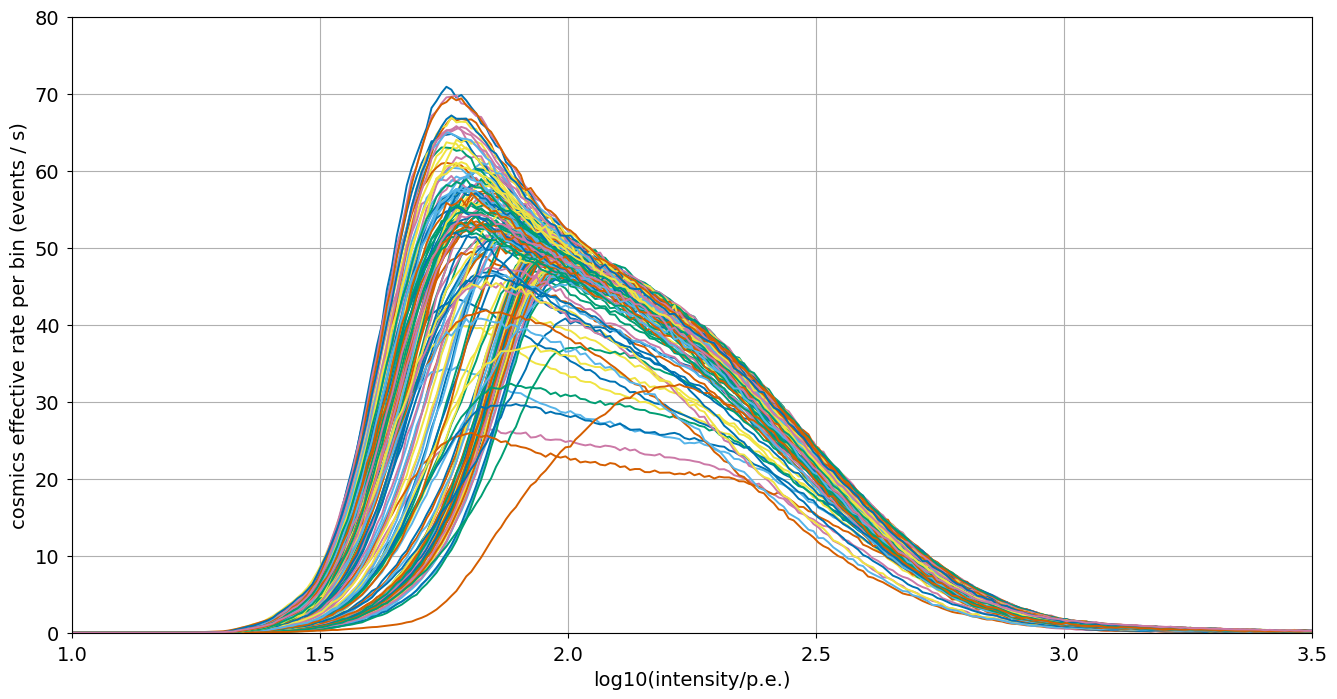

In [34]:
run_intensity_50 = []
intensity_peak_rate = []

intensity_spectrum = []

plt.figure(figsize=(16,8))

for i, run in enumerate(run_number):
    time = eff_time_per_run[i]

    log10intensity = 0.5*(bins_intensity[1:]+bins_intensity[:-1])
    plt.plot(log10intensity, num_evts[i,:] / time)

    
    curve = interp1d(log10intensity, num_evts[i,:] / time, 
                     bounds_error=False, fill_value='extrapolate')
    intensity_spectrum.append(curve)
    
    run_intensity_50.append(find50(curve))
    intensity_peak_rate.append(np.max(num_evts[i, :]) / time)

plt.grid()
#plt.xlim(1.25, 3.5)
#plt.ylim(0.05, 120)

# plt.xlim(1, 5)
# plt.ylim(0.001, 100)
#plt.yscale('log')

plt.xlim(1, 3.5)
plt.ylim(0, 80)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('log10(intensity/p.e.)', fontsize=14)
plt.ylabel('cosmics effective rate per bin (events / s)', fontsize=14)
plt.show()

run_intensity_50 = np.array(run_intensity_50)
intensity_peak_rate = np.array(intensity_peak_rate)

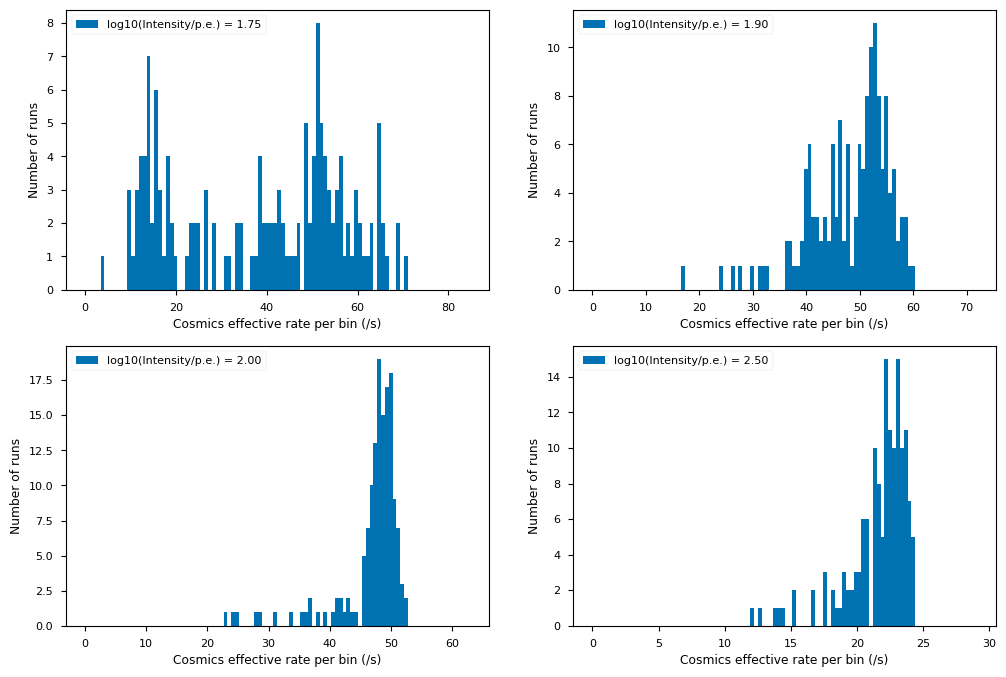

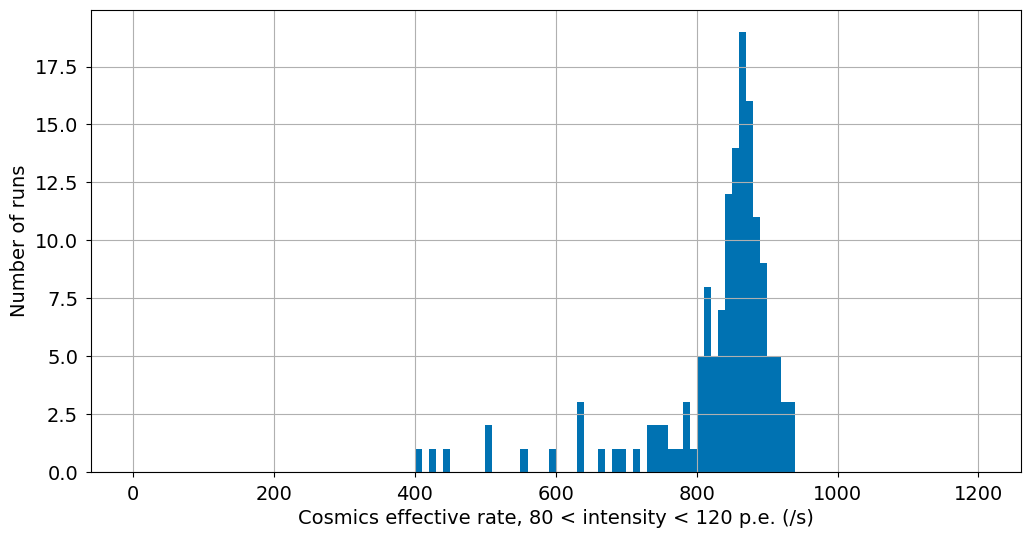

858.8749941538297 939.4172074374161
122 of 148
35.37 of 42.64 hours

Removed: [2913 2952 2953 2954 2955 2956 2957 2958 3678 3679 3954 3955 3956 3973
 3974 3975 4027 4028 4029 6148 6193 6194 6195 6242 7086 7198]


In [35]:
fig = plt.figure(figsize=(12, 8))

for k, log10i in enumerate([1.75, 1.9, 2, 2.5]):
    fig.add_subplot(2, 2, k+1)
    rates = np.array([ii(log10i) for ii in intensity_spectrum])
    plt.hist(rates, bins=100, range=(0, 1.2*np.max(rates)), label=f'log10(Intensity/p.e.) = {log10i:.2f}')
    plt.legend()
    plt.xlabel('Cosmics effective rate per bin (/s)')
    plt.ylabel('Number of runs')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(cosmics_per_run_i80to120/eff_time_per_run, bins=120, range=(0,1200))
plt.grid()
plt.xlabel('Cosmics effective rate, 80 < intensity < 120 p.e. (/s)', fontsize=14)
plt.ylabel('Number of runs', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# Selection in rate at 100 p.e.:
#runselection = np.array([ii(2.) for ii in intensity_spectrum]) > 46

print(np.median(cosmics_per_run_i80to120/eff_time_per_run), 
      np.max(cosmics_per_run_i80to120/eff_time_per_run))

runselection = (cosmics_per_run_i80to120/eff_time_per_run > 800) & (cosmics_per_run_i80to120/eff_time_per_run < 1000)

print(runselection.sum(), 'of', len(run_number))
print(f'{eff_time_per_run[runselection].sum()/3600:.2f} of {eff_time_per_run.sum()/3600:.2f} hours')

print()
print('Removed:', run_number[~runselection])

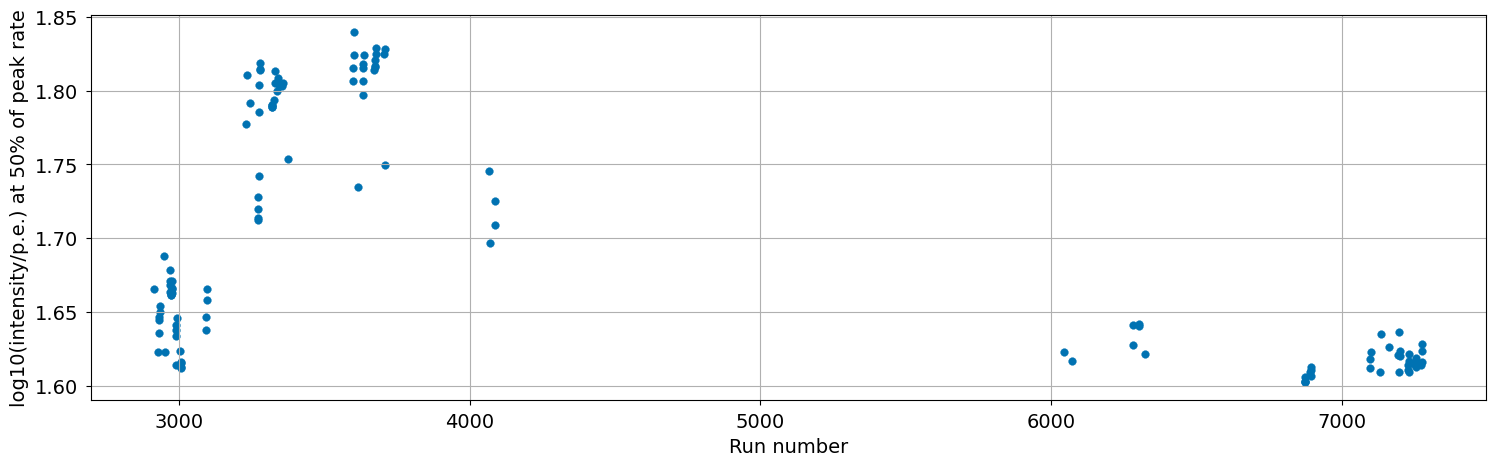

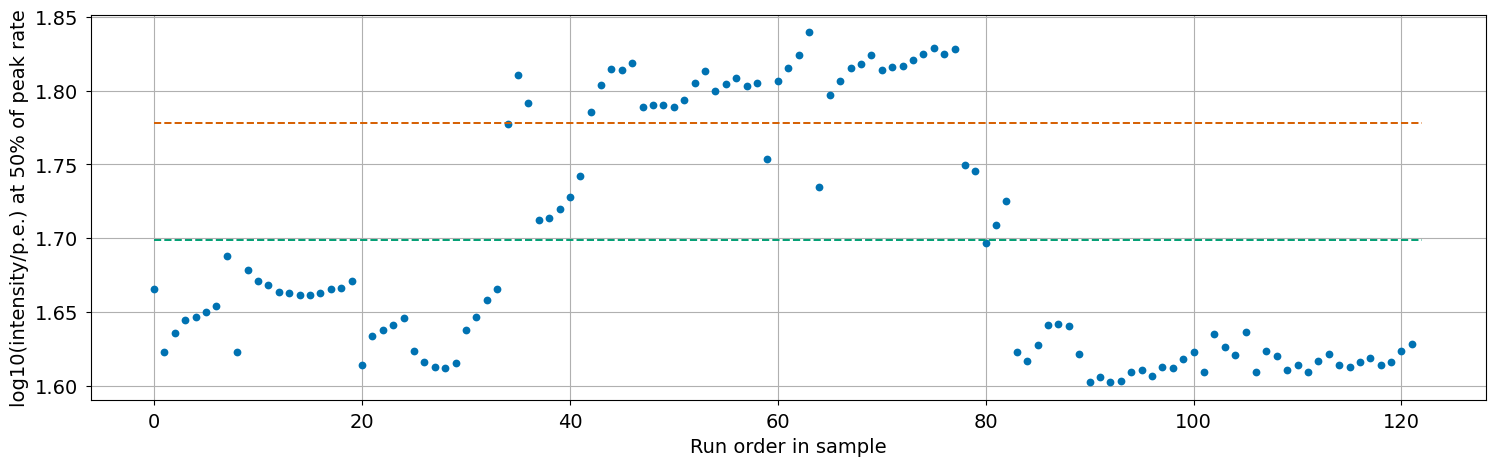

In [36]:
plt.figure(figsize=(18,5))
plt.scatter(run_number[runselection], run_intensity_50[runselection])
plt.xlabel('Run number', fontsize=14)
plt.ylabel('log10(intensity/p.e.) at 50% of peak rate', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

plt.figure(figsize=(18,5))
plt.plot(run_intensity_50[runselection], 'o')
plt.xlabel('Run order in sample', fontsize=14)
plt.ylabel('log10(intensity/p.e.) at 50% of peak rate', fontsize=14)
plt.plot(np.linspace(0, runselection.sum(), 100), np.log10(100*[50]), '--')
plt.plot(np.linspace(0, runselection.sum(), 100), np.log10(100*[60]), '--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid()
plt.show()

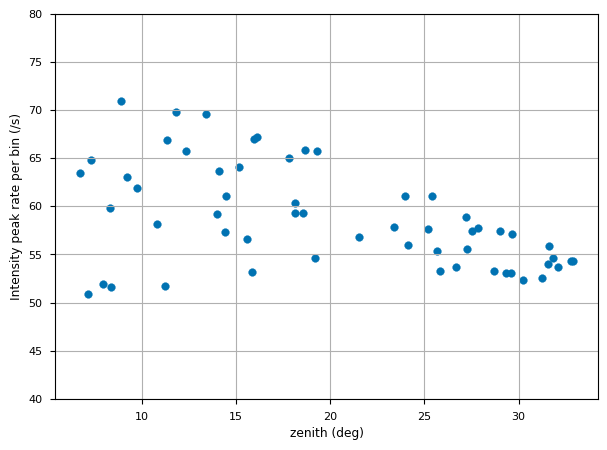

In [37]:
plt.figure(figsize=(7,5))
#select = run_intensity_50>1.77
select = run_intensity_50<1.65
#select = run_intensity_50 > 0
plt.scatter(zenith[select & runselection], intensity_peak_rate[select & runselection])
plt.xlabel('zenith (deg)')
plt.ylabel('Intensity peak rate per bin (/s)')
plt.ylim(40, 80)
plt.grid()
plt.show()

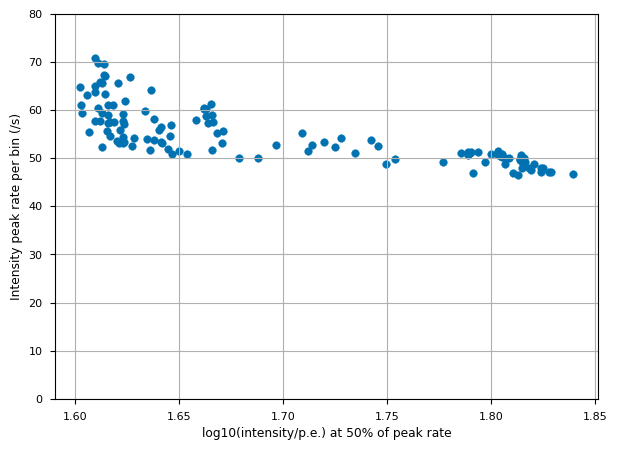

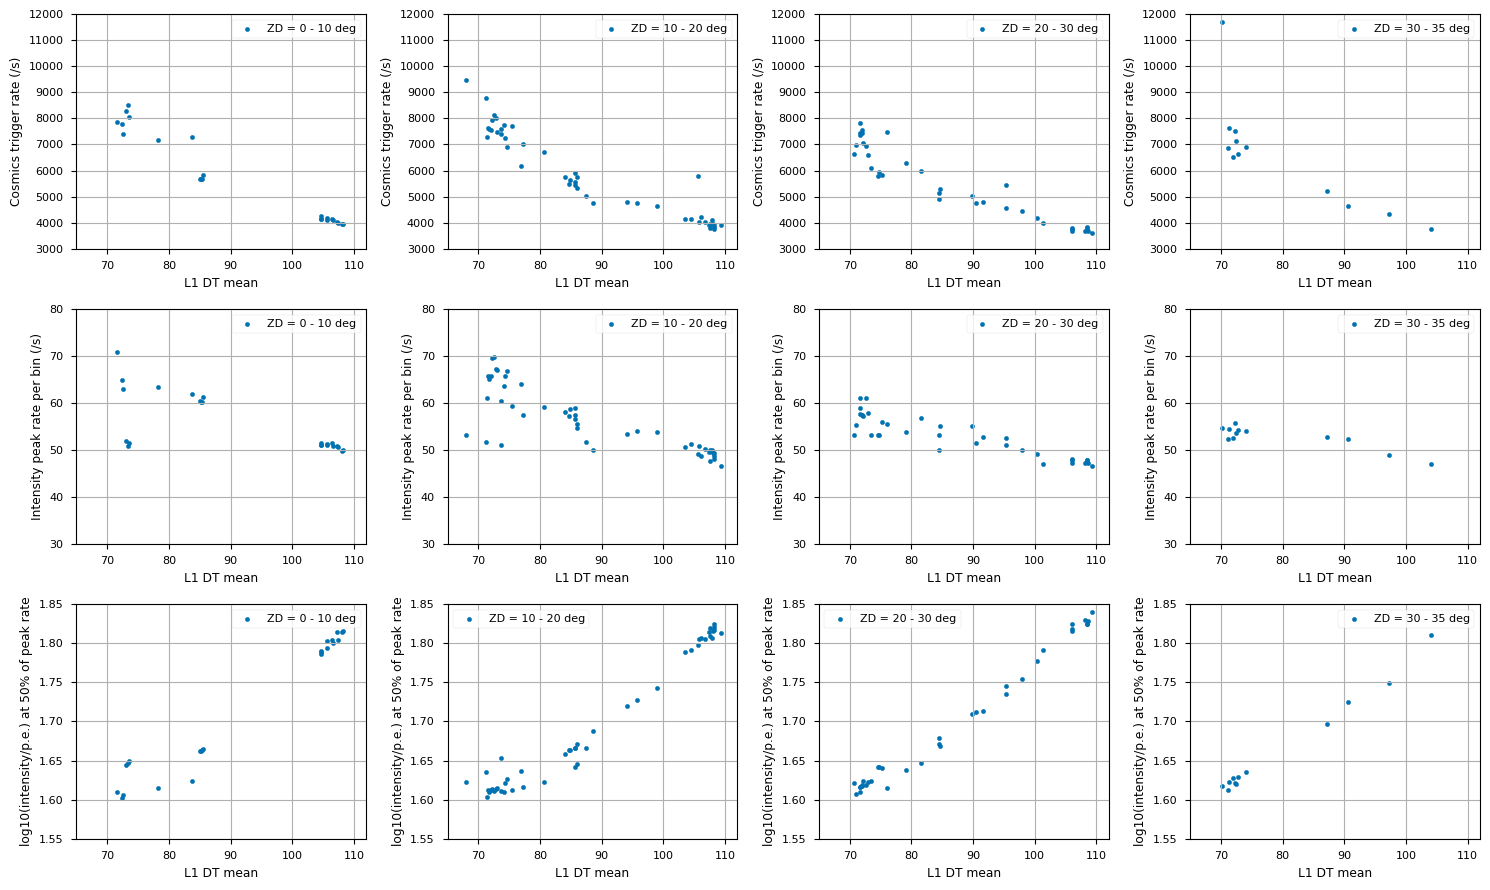

7097 65.80, 71.96,  1.61, 18.6
7161 66.87, 74.56,  1.63, 11.3
7195 65.70, 74.29,  1.62, 12.3
7197 65.05, 71.69,  1.61, 17.8
7227 69.75, 72.46,  1.61, 11.8
7228 66.99, 72.99,  1.61, 16.0
7253 69.58, 72.28,  1.61, 13.4
7254 65.71, 71.63,  1.61, 19.3
7274 67.19, 72.88,  1.61, 16.1


In [38]:
plt.figure(figsize=(7,5))
#select = run_intensity_50>1.77
#select = run_intensity_50<1.65
select = run_intensity_50 > 0
plt.scatter(run_intensity_50[select & runselection], intensity_peak_rate[select & runselection])
plt.ylabel('Intensity peak rate per bin (/s)')
plt.xlabel('log10(intensity/p.e.) at 50% of peak rate')
plt.ylim(0, 80)
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))

ipad = 0
for z1, z2 in zip ([0, 10, 20, 30], [10, 20, 30, 35]):
    zcut = (zenith > z1) & (zenith < z2)
    ipad += 1
    fig.add_subplot(3, 4, ipad)
    plt.scatter(l1_dt_mean[runselection & zcut], 
                triggered_cosmics_per_run[runselection & zcut] / elapsed_time_per_run[runselection & zcut], 
                s=10, label=f'ZD = {z1} - {z2} deg')
    plt.ylabel('Cosmics trigger rate (/s)')
    plt.xlabel('L1 DT mean')
    plt.ylim(3000, 12000)
    plt.xlim(65, 112)
    plt.grid()
    plt.legend()


for z1, z2 in zip ([0, 10, 20, 30], [10, 20, 30, 35]):
    zcut = (zenith > z1) & (zenith < z2)
    ipad += 1
    fig.add_subplot(3, 4, ipad)
    plt.scatter(l1_dt_mean[runselection & zcut], intensity_peak_rate[runselection & zcut], 
                s=10, label=f'ZD = {z1} - {z2} deg')
    plt.ylabel('Intensity peak rate per bin (/s)')
    plt.xlabel('L1 DT mean')
    plt.ylim(30, 80)
    plt.xlim(65, 112)
    plt.grid()
    plt.legend()

for z1, z2 in zip ([0, 10, 20, 30], [10, 20, 30, 35]):
    zcut = (zenith > z1) & (zenith < z2)
    ipad += 1
    fig.add_subplot(3, 4, ipad)
    plt.scatter(l1_dt_mean[runselection & zcut], run_intensity_50[runselection & zcut], 
                s=10, label=f'ZD = {z1} - {z2} deg')
    plt.ylabel('log10(intensity/p.e.) at 50% of peak rate')
    plt.xlabel('L1 DT mean')
    plt.ylim(1.55, 1.85)
    plt.xlim(65, 112)
    plt.grid()
    plt.legend()
    
plt.tight_layout()
plt.show()

for run, ipr, l1dt, th50, zz in zip(run_number[runselection],
                                    intensity_peak_rate[runselection],
                                    l1_dt_mean[runselection],
                                    run_intensity_50[runselection],
                                    zenith[runselection]):
    if (zz < 10) | (zz > 20):
        continue
    if ipr < 65:
        continue
    if l1dt > 75:
        continue
    print(f'{run} {ipr:5.2f}, {l1dt:5.2f}, {th50:5.2f}, {zz:.1f}')

In [39]:
cb_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(cb_colors)

['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']


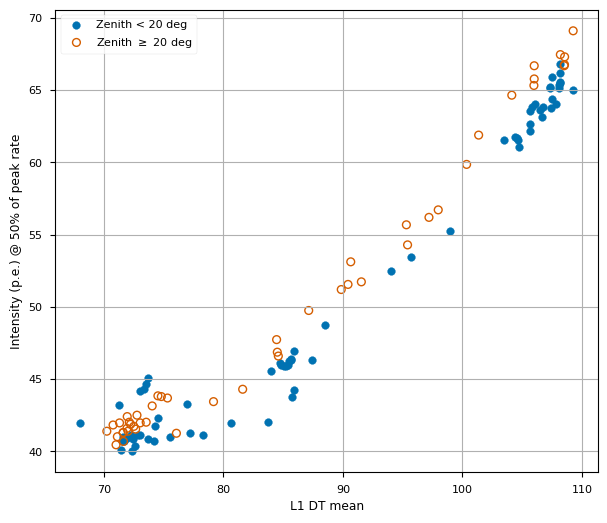

In [40]:
plt.figure(figsize=(7,6))
plt.scatter(l1_dt_mean[runselection & (zenith<20)], 10**run_intensity_50[runselection & (zenith<20)],
           color=cb_colors[0],
           label='Zenith < 20 deg')
plt.scatter(l1_dt_mean[runselection & (zenith>=20)], 10**run_intensity_50[runselection & (zenith>=20)],
           facecolors='none', edgecolors=cb_colors[2],
           linewidths=1,
           label='Zenith $\geq$ 20 deg')

plt.xlabel('L1 DT mean')
plt.ylabel('Intensity (p.e.) @ 50% of peak rate')
plt.grid()
plt.legend()
plt.show()

In [41]:
len(run_intensity_50[runselection])

122

In [42]:
# Read in the Crab light curve (from D. Morcuende's source-independent analysis for the Crab paper)
lightcurve = Table.read("LC_Crab_LST_performance_src_indep_runwise.ecsv")
lightcurve.columns

<TableColumns names=('time_min','time_max','e_ref','e_min','e_max','flux','flux_err','flux_errp','flux_errn','flux_ul','ts','sqrt_ts','npred','npred_excess','stat','is_ul','counts','success','norm_scan','stat_scan')>

In [43]:
print("Light curve contains one point per run,", len(lightcurve), "runs")

Light curve contains one point per run, 117 runs


In [60]:
# The run numbers in the paper are these:
paper_runs = [2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968, 2969,
              2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989, 2990, 2991,
              2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095, 3096, 3231, 3232,
              3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3318,
              3319, 3320, 3321, 3328, 3329, 3330, 3338, 3339, 3340, 3355, 3356, 3373,
              3598, 3599, 3600, 3601, 3615, 3632, 3633, 3634, 3635, 3672, 3673, 3674,
              3675, 3676, 3677, 3706, 3707, 3708, 4067, 4068, 4086, 4087, 6045, 6073,
              6304, 6872, 6873, 6874, 6875, 6892, 6893, 6894, 6895, 7097, 7098, 7099,
              7133, 7136, 7161, 7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231, 7232,
              7233, 7253, 7254, 7255, 7256, 7274, 7275, 7276, 7277]


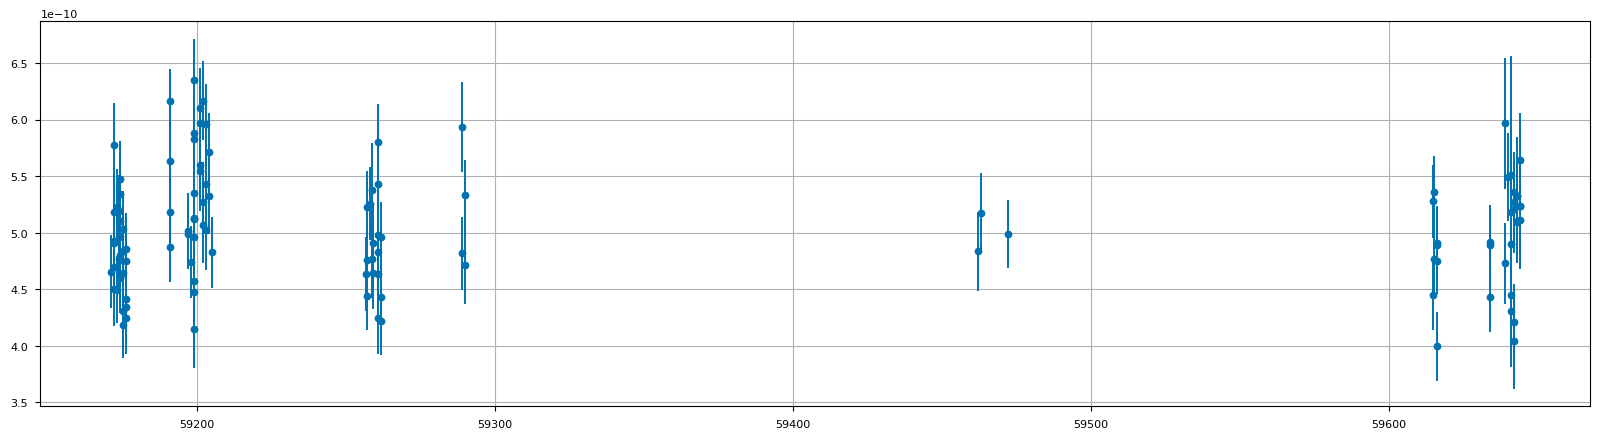

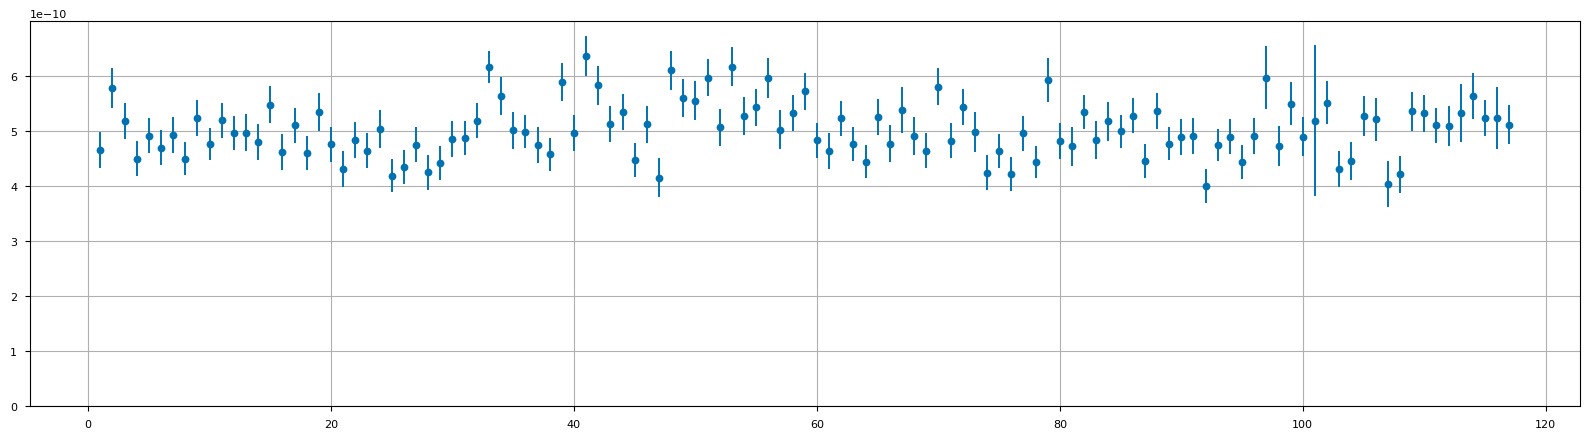

In [44]:
runflux = np.squeeze(lightcurve['flux'])
runfluxerr = np.squeeze(lightcurve['flux_err'])

plt.figure(figsize=(20,5))
plt.errorbar(0.5*(lightcurve['time_min']+lightcurve['time_max']), runflux,
             yerr=runfluxerr, fmt='o')
plt.grid()
plt.show()

plt.figure(figsize=(20,5))
plt.errorbar(np.linspace(1,117,117), runflux, runfluxerr, fmt='o')
plt.ylim(0, 1.1*np.max(runflux))
plt.grid()
plt.show()

In [64]:
run_is_in_paper = np.array([True if x in paper_runs else False for x in run_number])

In [66]:
# Since here we only have the flux for the 117 runs in the paper, we have to put fill-in values for
# the runs in the current runselection which are not among the 117...

In [67]:
CR_rate_around_100 = rate_80_120[runselection & run_is_in_paper]
CR_rate_around_300 = rate_280_320[runselection & run_is_in_paper]

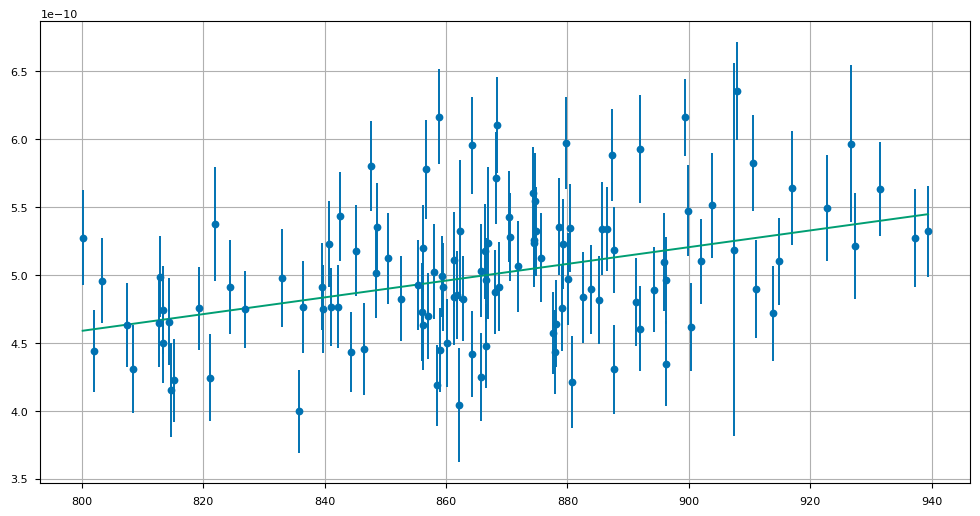

array([142.18429031, 148.33829285, 148.40330013, 152.28628941,
       147.55861886, 150.2206283 , 149.21279295, 143.87420289,
       152.27146277, 141.49286602, 145.60947862, 147.57511743,
       149.55516617, 150.00951437, 151.80655557, 151.74464086,
       151.10137037, 149.87047272, 148.71199323, 147.0781704 ,
       152.81344696, 152.04786163, 150.66598804, 148.90241341,
       147.12710627, 154.29876233, 143.42785742, 148.41454834,
       147.48335488, 146.07045486, 147.42739685, 150.89082336,
       153.18035985, 157.81883738, 149.55146185, 146.19856275,
       156.37279068, 149.84048067, 153.46748031, 156.1179542 ,
       158.65860843, 160.1834576 , 159.53390572, 160.99711997,
       159.37590185, 156.7541745 , 152.59558726, 156.60034268,
       157.70101616, 157.27765264, 157.81063592, 157.50771995,
       155.74425519, 159.86950509, 157.2676607 , 155.04526696,
       154.66400537, 157.66014905, 155.32197693, 149.73429702,
       160.63764802, 158.58346148, 156.58704268, 150.42

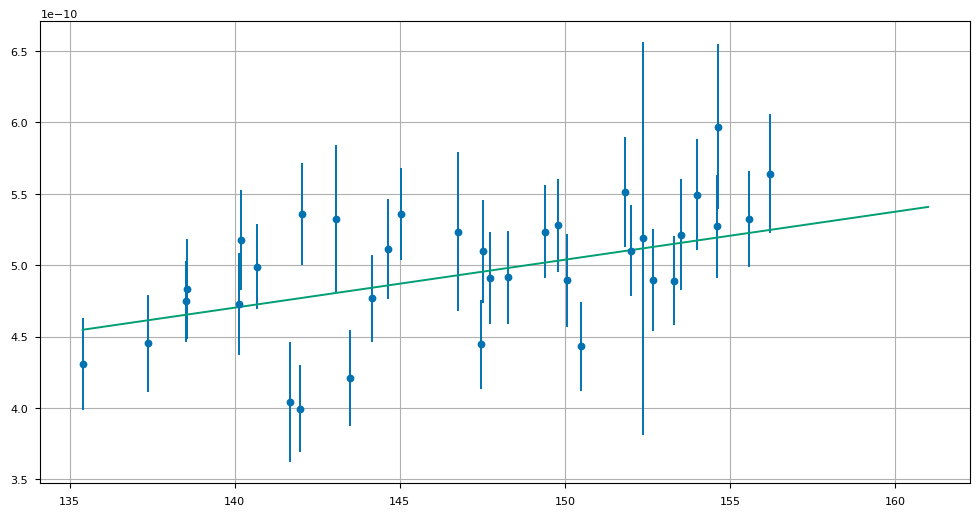

In [68]:
def pol1(x, a, b):
    return a + b*x

def pol1b(x, b):
    return b*x

params, cv = curve_fit(pol1, CR_rate_around_100, runflux, (0, 0), sigma=runfluxerr, absolute_sigma=True)

plt.figure(figsize=(12,6))
plt.errorbar(CR_rate_around_100, runflux, yerr=runfluxerr, fmt='o')
plt.plot([CR_rate_around_100.min(), CR_rate_around_100.max()], 
         [pol1(CR_rate_around_100.min(), params[0], params[1]),
          pol1(CR_rate_around_100.max(), params[0], params[1])])
plt.grid()
plt.show()
#print(CR_rate_around_100)

params, cv = curve_fit(pol1b, CR_rate_around_300[82:], runflux[82:], (0), 
                       sigma=runfluxerr[82:], absolute_sigma=True)

plt.figure(figsize=(12,6))
plt.errorbar(CR_rate_around_300[82:], runflux[82:], yerr=runfluxerr[82:], fmt='o')
plt.plot([CR_rate_around_300.min(), CR_rate_around_300.max()], 
         [pol1b(CR_rate_around_300.min(), params[0]),
          pol1b(CR_rate_around_300.max(), params[0])])

print(repr(CR_rate_around_300))


plt.grid()
plt.show()



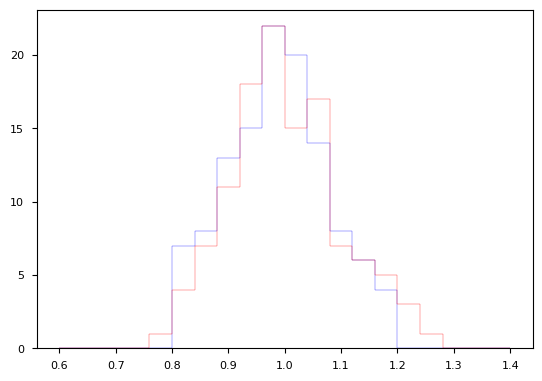

0.08774260969422834
0.09897049992901749


In [69]:
#runflux_corr = runflux/pol1(CR_rate_around_100, params[0], params[1])
runflux_corr = runflux/pol1b(CR_rate_around_300, params[0])

plt.hist(runflux_corr, bins=20, range=(0.6,1.4), histtype='step', color='b')
plt.hist(runflux/runflux.mean(), bins=20, range=(0.6,1.4), histtype='step', color='r')


plt.show()

print(runflux_corr.std())
print((runflux/runflux.mean()).std())


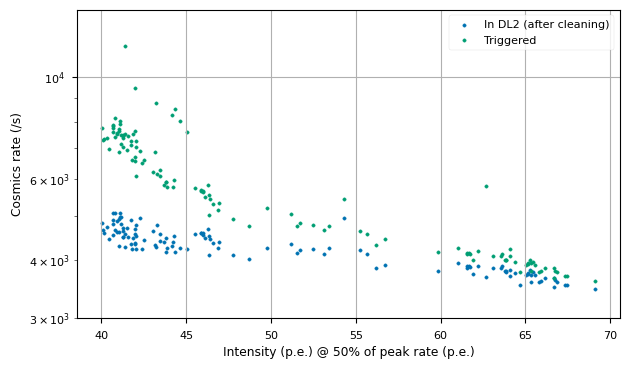

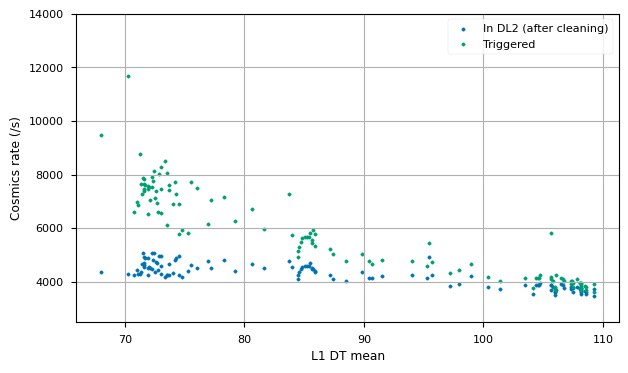

In [70]:
plt.figure(figsize=(7, 4))
plt.scatter(10**run_intensity_50[runselection], 
            (cosmics_per_run/elapsed_time_per_run)[runselection], label='In DL2 (after cleaning)', s=6)
plt.scatter(10**run_intensity_50[runselection], 
            (triggered_cosmics_per_run/elapsed_time_per_run)[runselection], label='Triggered', s=6)
plt.xlabel('Intensity (p.e.) @ 50% of peak rate (p.e.)')
plt.ylabel('Cosmics rate (/s)')
plt.legend()
plt.ylim(3000,14000)
plt.yscale('log')
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(l1_dt_mean[runselection], 
            (cosmics_per_run/elapsed_time_per_run)[runselection], label='In DL2 (after cleaning)', s=6)
plt.scatter(l1_dt_mean[runselection], 
            (triggered_cosmics_per_run/elapsed_time_per_run)[runselection], label='Triggered', s=6)
plt.xlabel('L1 DT mean')
plt.ylabel('Cosmics rate (/s)')
plt.legend()
plt.ylim(2500,14000)
#plt.yscale('log')
plt.grid()
plt.show()

In [71]:
run_number[runselection][(triggered_cosmics_per_run/elapsed_time_per_run)[runselection]>7600]

array([2929, 2930, 2931, 2932, 2933, 2934, 3006, 6045, 6073, 6872, 6892,
       7133, 7227, 7231, 7253, 7254, 7274])

In [72]:
triggered_cosmics_per_run[np.where(run_number==2934)[0][0]]/elapsed_time_per_run[np.where(run_number==2934)[0][0]]
10**run_intensity_50[np.where(run_number==2934)[0][0]]

45.06723213307371

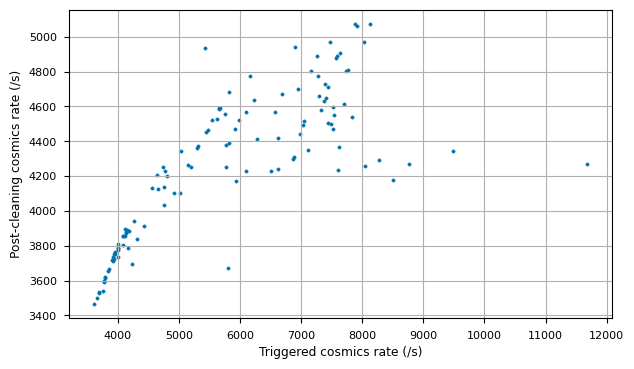

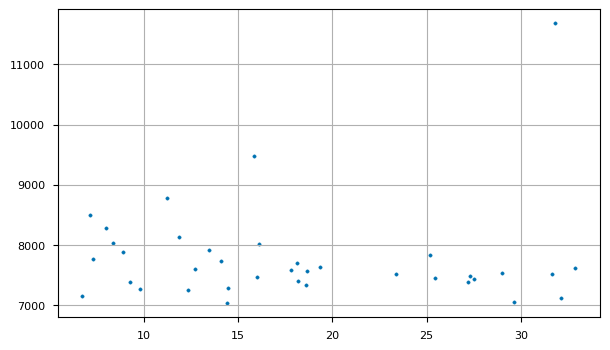

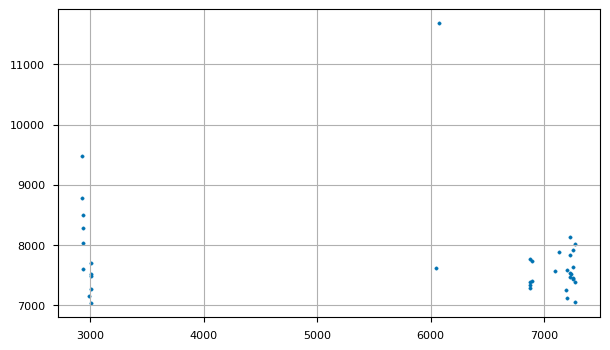

In [73]:
plt.figure(figsize=(7, 4))
plt.scatter((triggered_cosmics_per_run/elapsed_time_per_run)[runselection],
            (cosmics_per_run/elapsed_time_per_run)[runselection], s=6)
plt.xlabel('Triggered cosmics rate (/s)')
plt.ylabel('Post-cleaning cosmics rate (/s)')
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
highratemask = triggered_cosmics_per_run/elapsed_time_per_run > 7000
plt.scatter(zenith[runselection & highratemask],
            (triggered_cosmics_per_run/elapsed_time_per_run)[runselection & highratemask], 
            s=6)
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
highratemask = triggered_cosmics_per_run/elapsed_time_per_run > 7000
plt.scatter(run_number[runselection & highratemask],
            (triggered_cosmics_per_run/elapsed_time_per_run)[runselection & highratemask], 
            s=6)
plt.grid()
plt.show()

[ 5.72605843e+03 -1.67739985e+00]


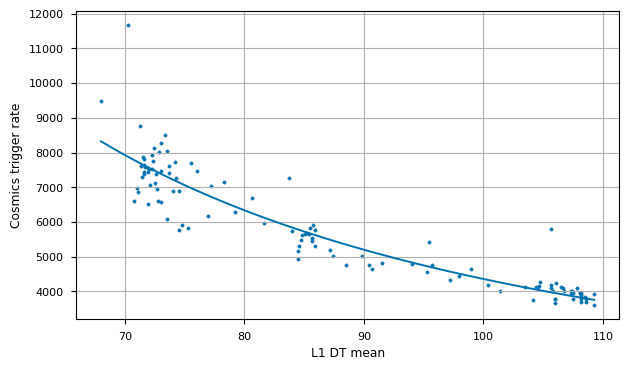

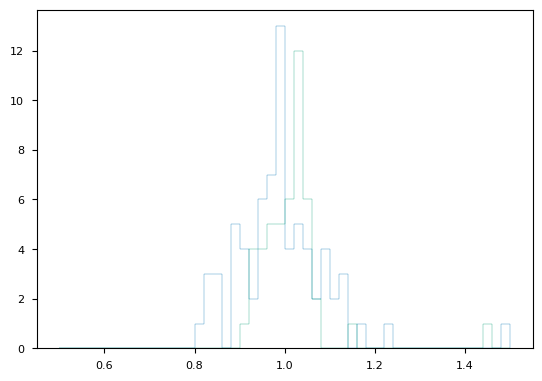

In [74]:
def powlaw(x, a, b):
    return a*(x/85)**b

plt.figure(figsize=(7, 4))

xx = l1_dt_mean[runselection]
yy = (triggered_cosmics_per_run/elapsed_time_per_run)[runselection]
#yy = (cosmics_per_run/elapsed_time_per_run)[runselection]

plt.scatter(xx, yy, s=6)

p0 = (6000, -1.5) 
params, cv = curve_fit(powlaw, xx[~np.isnan(xx)], yy[~np.isnan(xx)], p0)
print(params)
fxx = np.linspace(np.nanmin(xx), np.nanmax(xx), 100)
plt.plot(fxx, powlaw(fxx, params[0], params[1]))

plt.xlabel('L1 DT mean')
plt.ylabel('Cosmics trigger rate')
#plt.ylim(0, 13000)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.show()

plt.hist(yy[xx<90]/powlaw(xx[xx<90], params[0], params[1]), bins=50, range=(0.5, 1.5), histtype='step')
plt.hist(yy[xx>90]/powlaw(xx[xx>90], params[0], params[1]), bins=50, range=(0.5, 1.5), histtype='step')

plt.show()


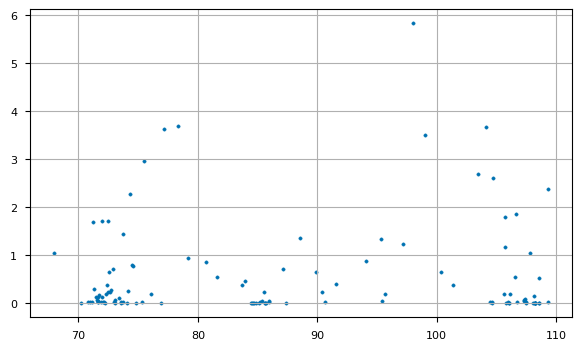

In [75]:
plt.figure(figsize=(7, 4))
plt.scatter(l1_dt_mean[runselection], l1_dt_std[runselection],
            s=6)
plt.grid()
plt.show()

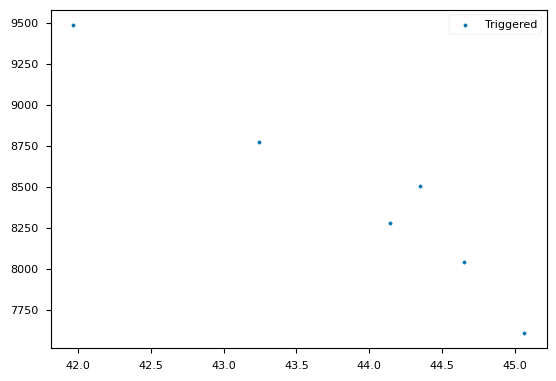

In [76]:
plt.scatter(10**run_intensity_50[(run_number>2928) & (run_number<2935)], 
            (triggered_cosmics_per_run/elapsed_time_per_run)[(run_number>2928) & (run_number<2935)], 
            label='Triggered', s=6)
plt.legend()
plt.show()

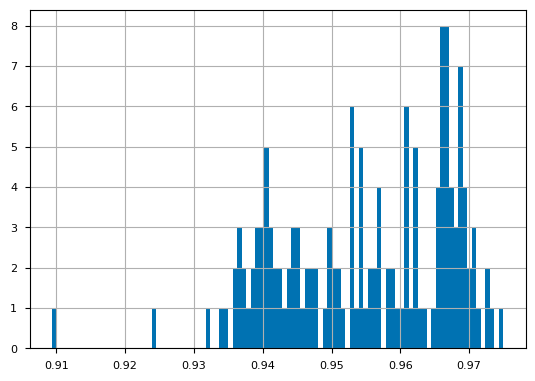

In [77]:
plt.hist(eff_time_per_run/elapsed_time_per_run, bins=100)
plt.grid()
plt.show()

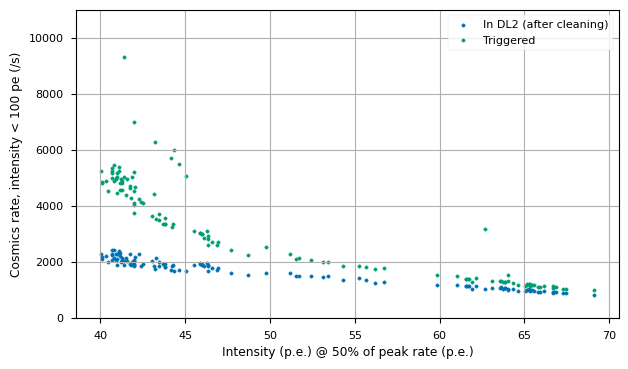

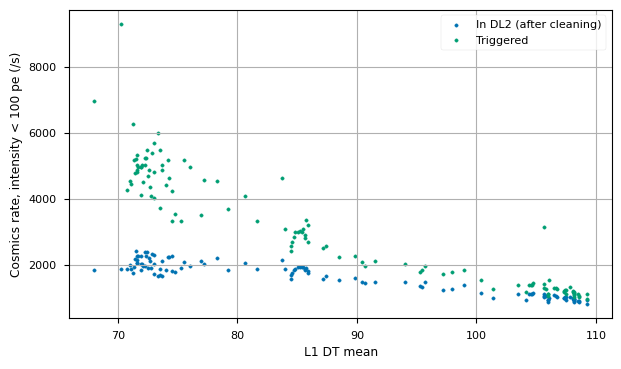

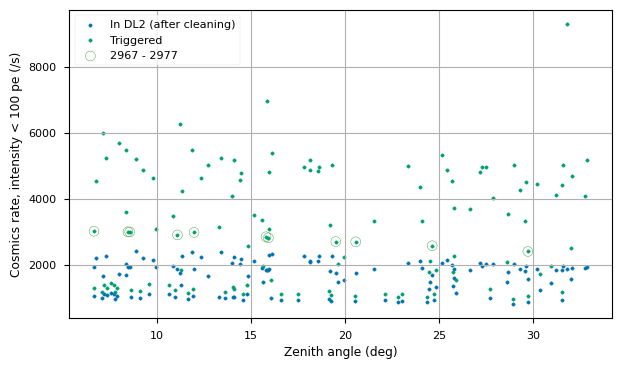

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


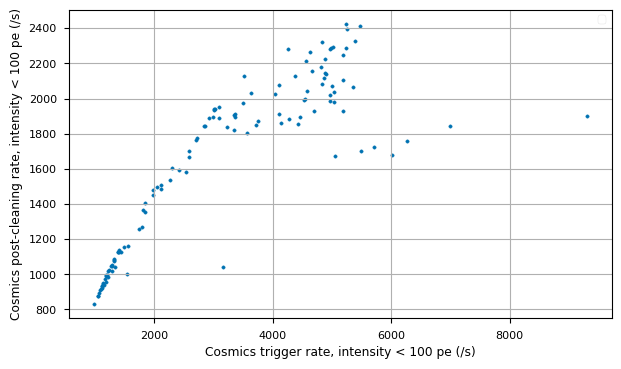

In [78]:
plt.figure(figsize=(7, 4))
plt.scatter(10**run_intensity_50[runselection], 
            ((cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            label='In DL2 (after cleaning)', s=6)
plt.scatter(10**run_intensity_50[runselection], 
            ((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            label='Triggered', s=6)
plt.xlabel('Intensity (p.e.) @ 50% of peak rate (p.e.)')
plt.ylabel('Cosmics rate, intensity < 100 pe (/s)')
plt.legend()
plt.ylim(0, 11000)
#plt.yscale('log')
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(l1_dt_mean[runselection], 
            ((cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            label='In DL2 (after cleaning)', s=6)
plt.scatter(l1_dt_mean[runselection], 
            ((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            label='Triggered', s=6)
plt.xlabel('L1 DT mean')
plt.ylabel('Cosmics rate, intensity < 100 pe (/s)')
plt.legend()
#plt.ylim(0, 11000)
#plt.yscale('log')
plt.grid()
plt.show()



plt.figure(figsize=(7, 4))
plt.scatter(zenith[runselection], 
            ((cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            label='In DL2 (after cleaning)', s=6)
plt.scatter(zenith[runselection], 
            ((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
             label='Triggered', s=6)

plt.scatter(zenith[runselection & (run_number>2966) & (run_number<2978)], 
            ((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection & (run_number>2966) & (run_number<2978)], 
             label='2967 - 2977', s=50, facecolors='none', edgecolors='green')


plt.xlabel('Zenith angle (deg)')
plt.ylabel('Cosmics rate, intensity < 100 pe (/s)')
#plt.ylim(0, 4000)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            ((cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            s=6)
plt.xlabel('')
plt.xlabel('Cosmics trigger rate, intensity < 100 pe (/s)')
plt.ylabel('Cosmics post-cleaning rate, intensity < 100 pe (/s)')
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2879.28206357   -3.48309166]


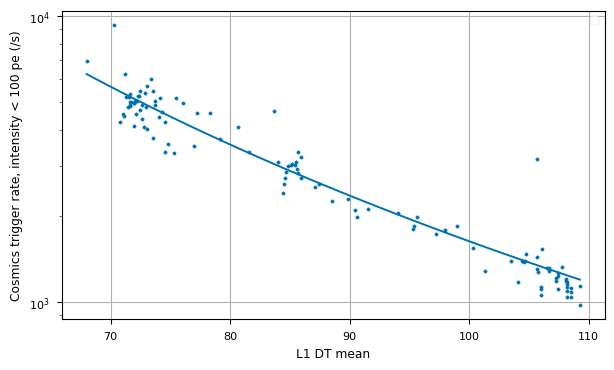

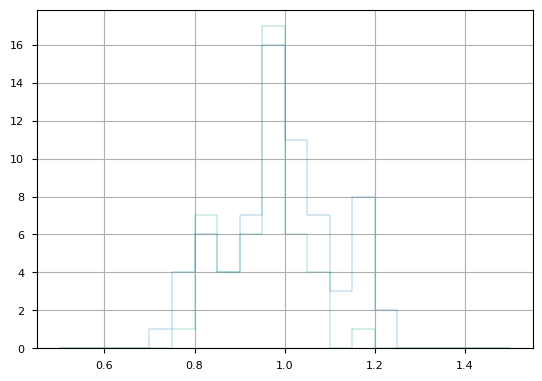

In [79]:
plt.figure(figsize=(7, 4))

xx = l1_dt_mean[runselection]
yy = ((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection]
plt.scatter(xx, yy, s=6)

p0 = (6000, -1.5) 
params, cv = curve_fit(powlaw, xx[~np.isnan(xx)], yy[~np.isnan(xx)], p0)
print(params)

fxx = np.linspace(np.nanmin(xx), np.nanmax(xx), 100)
plt.plot(fxx, powlaw(fxx, params[0], params[1]))

plt.ylabel('Cosmics trigger rate, intensity < 100 pe (/s)')
plt.xlabel('L1 DT mean')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()


plt.hist(yy[xx<90]/powlaw(xx[xx<90], params[0], params[1]), bins=20, range=(0.5, 1.5), histtype='step')
plt.hist(yy[xx>90]/powlaw(xx[xx>90], params[0], params[1]), bins=20, range=(0.5, 1.5), histtype='step')
plt.grid()
plt.show()

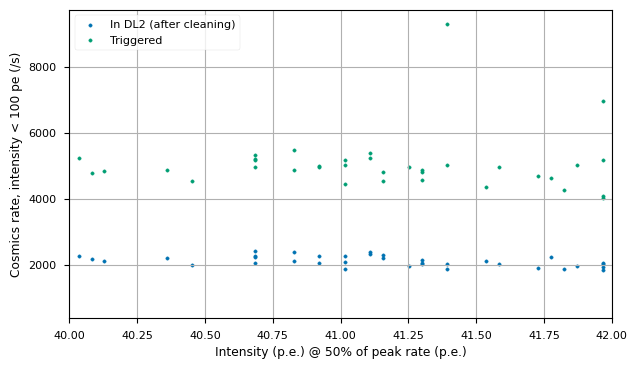

In [80]:
plt.figure(figsize=(7, 4))
plt.scatter(10**run_intensity_50[runselection], 
            ((cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            label='In DL2 (after cleaning)', s=6)
plt.scatter(10**run_intensity_50[runselection], 
            ((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run)[runselection], 
            label='Triggered', s=6)
plt.xlabel('Intensity (p.e.) @ 50% of peak rate (p.e.)')
plt.ylabel('Cosmics rate, intensity < 100 pe (/s)')
plt.legend()
plt.xlim(40, 42)
#plt.yscale('log')
plt.grid()
plt.show()

In [81]:
run_number[runselection]

array([2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968,
       2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
       2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095,
       3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
       3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338,
       3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601, 3615, 3631,
       3632, 3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706,
       3707, 3708, 4067, 4068, 4086, 4087, 6045, 6073, 6281, 6282, 6303,
       6304, 6324, 6872, 6873, 6874, 6875, 6892, 6893, 6894, 6895, 7097,
       7098, 7099, 7133, 7136, 7161, 7195, 7196, 7197, 7199, 7200, 7227,
       7228, 7231, 7232, 7233, 7253, 7254, 7255, 7256, 7274, 7275, 7276,
       7277])

In [82]:
for a, b, c, d, e, f in zip (run_number, run_intensity_50, l1_dt_mean, zenith,
                             triggered_cosmics_per_run/elapsed_time_per_run,
                             cosmics_per_run/elapsed_time_per_run):
    if a not in run_number[runselection]:
        continue
    if c > 87:
        continue
    if c < 82:
        continue
    #if (d < 0) | (d > 15):
    #    continue
    print (f'{a} {b:7.2f} {c:7.2f} {d:7.2f} {e:7.2f} {f:7.2f}')

2967    1.68   84.45   29.74 4924.52 4101.16
2968    1.67   84.51   24.65 5152.22 4262.66
2969    1.67   84.60   20.58 5304.81 4359.28
2970    1.66   84.71   15.81 5480.76 4463.50
2971    1.66   84.86   11.98 5630.19 4529.24
2972    1.66   85.11    8.46 5664.83 4585.68
2973    1.66   85.21    6.65 5680.59 4592.13
2974    1.66   85.39    8.55 5662.16 4592.15
2975    1.67   85.63   11.09 5551.03 4519.63
2976    1.67   85.66   15.93 5442.21 4455.36
2977    1.67   85.92   19.52 5315.67 4375.10
2989    1.63     nan    8.33 6228.07 4634.53
2990    1.64     nan   10.83 6093.76 4567.38
2991    1.64   85.72   15.62 5920.15 4473.04
2992    1.65   85.95   19.23 5770.46 4379.96
3004    1.62   83.70    9.78 7274.82 4775.97
3007    1.61     nan   23.38 7527.03 4596.73
3095    1.66   83.98   15.96 5753.94 4555.18
3096    1.67   85.52    9.97 5829.40 4685.02
6875    1.60     nan   18.58 7329.70 4577.78


In [83]:
print(run_number[np.where((triggered_cosmics_per_run - cosmics_per_run_igt100)/elapsed_time_per_run>6000)[0]])

[2929 2930 2932 6073]


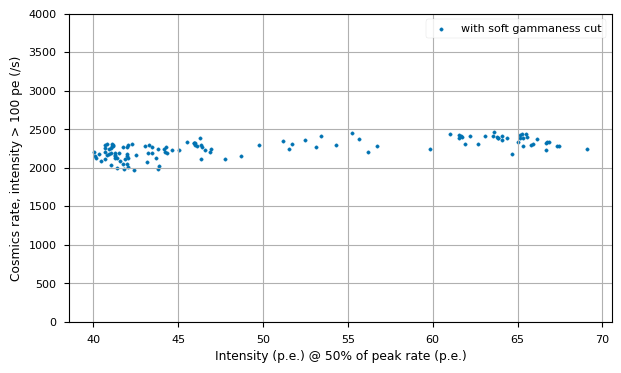

In [84]:
plt.figure(figsize=(7, 4))
# plt.scatter(10**run_intensity_50[runselection], 
#             (cosmics_per_run_igt100/elapsed_time_per_run)[runselection], s=6)
plt.scatter(10**run_intensity_50[runselection], 
            (cosmics_per_run_igt100_soft_gcut/elapsed_time_per_run)[runselection], s=6,
           label='with soft gammaness cut')

plt.xlabel('Intensity (p.e.) @ 50% of peak rate (p.e.)')
plt.ylabel('Cosmics rate, intensity > 100 pe (/s)')
plt.ylim(0, 4000)
plt.grid()
plt.legend()
plt.show()

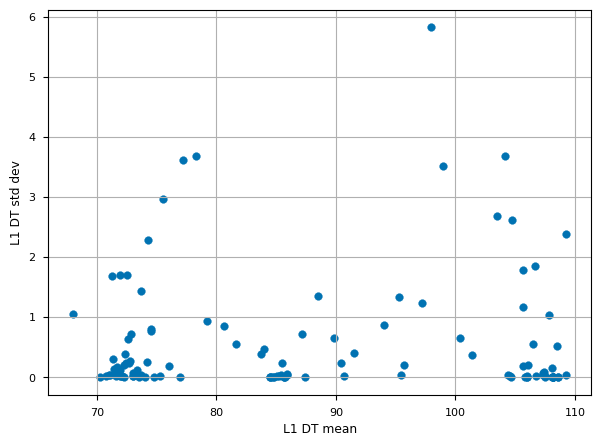

In [85]:
plt.figure(figsize=(7,5))
plt.scatter(l1_dt_mean[runselection], l1_dt_std[runselection])
plt.xlabel('L1 DT mean')
plt.ylabel('L1 DT std dev')
plt.grid()
plt.show()


In [86]:
run_number[runselection]

array([2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968,
       2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
       2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095,
       3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
       3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338,
       3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601, 3615, 3631,
       3632, 3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706,
       3707, 3708, 4067, 4068, 4086, 4087, 6045, 6073, 6281, 6282, 6303,
       6304, 6324, 6872, 6873, 6874, 6875, 6892, 6893, 6894, 6895, 7097,
       7098, 7099, 7133, 7136, 7161, 7195, 7196, 7197, 7199, 7200, 7227,
       7228, 7231, 7232, 7233, 7253, 7254, 7255, 7256, 7274, 7275, 7276,
       7277])

In [87]:
len(run_number)

148

In [88]:
runselection.sum()

122

In [89]:
# Runs which survive the mean pixel rate cut (for qpix > 30 pe), from the DL1 data check!

qpix_gt_30_rate_cut = np.array([2771, 2913, 2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950,
                                2955, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976,
                                2977, 2988, 2989, 2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008,
                                3093, 3094, 3095, 3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273,
                                3274, 3275, 3276, 3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328,
                                3329, 3330, 3338, 3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600,
                                3601, 3615, 3632, 3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676,
                                3677, 3678, 3679, 3706, 3707, 3708, 3954, 3955, 3974, 4027, 4067,
                                4068, 4086, 4087, 6045, 6073, 6148, 6195, 6304, 6871, 6872, 6873,
                                6874, 6875, 6892, 6893, 6894, 6895, 7084, 7086, 7097, 7098, 7099,
                                7133, 7136, 7161, 7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231,
                                7232, 7233, 7253, 7254, 7255, 7256, 7274, 7275, 7276, 7277])

# Runs which survive the mean pixel rate cut (for qpix > 10 pe), from the DL1 data check!

qpix_gt_10_rate_cut = np.array([2771, 2913, 2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950,
                               2952, 2953, 2954, 2955, 2956, 2958, 2967, 2968, 2969, 2970, 2971,
                               2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989, 2990, 2991, 2992,
                               3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095, 3096, 3231, 3232,
                               3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279,
                               3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338, 3339, 3340, 3355,
                               3356, 3373, 3598, 3599, 3600, 3601, 3615, 3631, 3632, 3633, 3634,
                               3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706, 3707, 3708, 3954,
                               3955, 3974, 4027, 4067, 4068, 4086, 4087, 6045, 6073, 6148, 6193,
                               6194, 6195, 6242, 6281, 6282, 6303, 6304, 6324, 6872, 6873, 6874,
                               6875, 6892, 6893, 6894, 6895, 7086, 7097, 7098, 7099, 7133, 7136,
                               7161, 7195, 7196, 7197, 7198, 7199, 7200, 7227, 7228, 7231, 7232,
                               7233, 7253, 7254, 7255, 7256, 7274, 7275, 7276, 7277])

In [90]:
final_selected_runs = [r for r in run_number[runselection] if r in qpix_gt_30_rate_cut]
# (these will be the same as in the paper, since this was the way in which they were selected)

In [94]:
runselection_except_pixrate_cuts  = runselection

runselection_final = np.array([True if r in final_selected_runs else False for r in run_number])

In [95]:
runselection = runselection_final

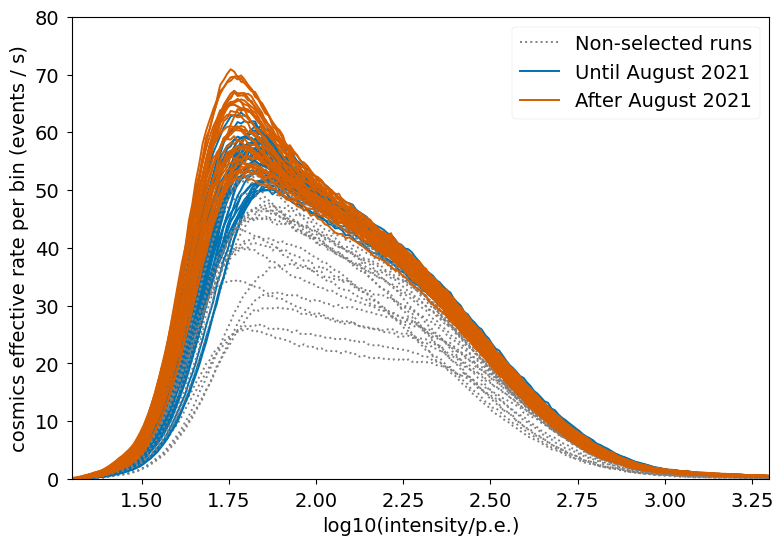

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2913 2914 2929 2930 2931 2932 2933 2934 2949 2950 2952 2953 2954 2955
 2956 2957 2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977 2988
 2989 2990 2991 2992 3004 3005 3006 3007 3008 3093 3094 3095 3096 3973
 3974 3975 4027 4028 4029 4068 6045 6073 6148 6193 6194 6195 6242 6281
 6282 6303 6304 6324 6872 6873 6874 6875 6892 6893 6894 6895 7097 7098
 7099 7133 7136 7161 7195 7196 7197 7198 7199 7200 7227 7228 7231 7232
 7233 7253 7254 7255 7256 7274 7275 7276 7277]
teff = 26.06 h


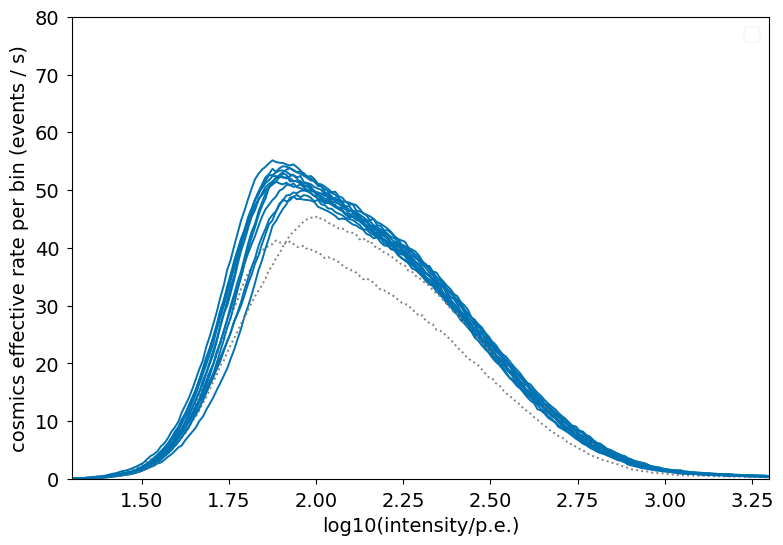

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2958 3231 3270 3271 3272 3273 3274 3373 3615 3708 3954 4067 4086 4087]
teff = 4.24 h


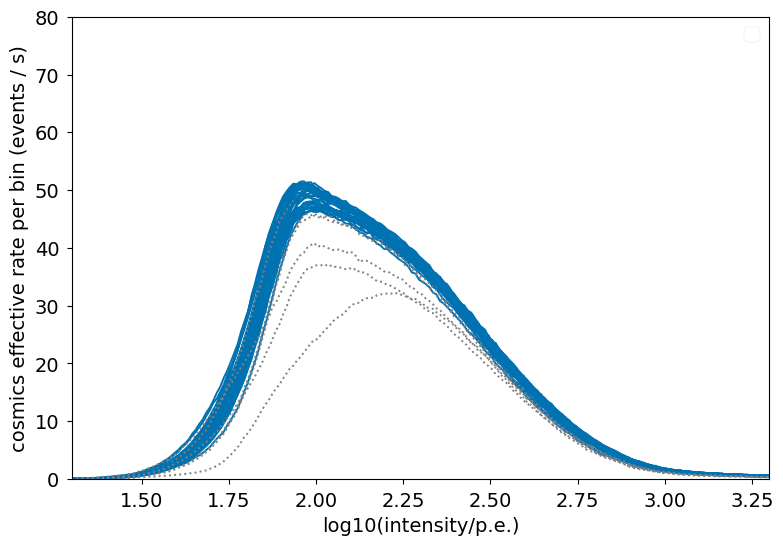

[3232 3243 3275 3276 3277 3278 3279 3318 3319 3320 3321 3328 3329 3330
 3338 3339 3340 3355 3356 3598 3599 3600 3601 3631 3632 3633 3634 3635
 3672 3673 3674 3675 3676 3677 3678 3679 3706 3707 3955 3956 7086]
teff = 12.33 h


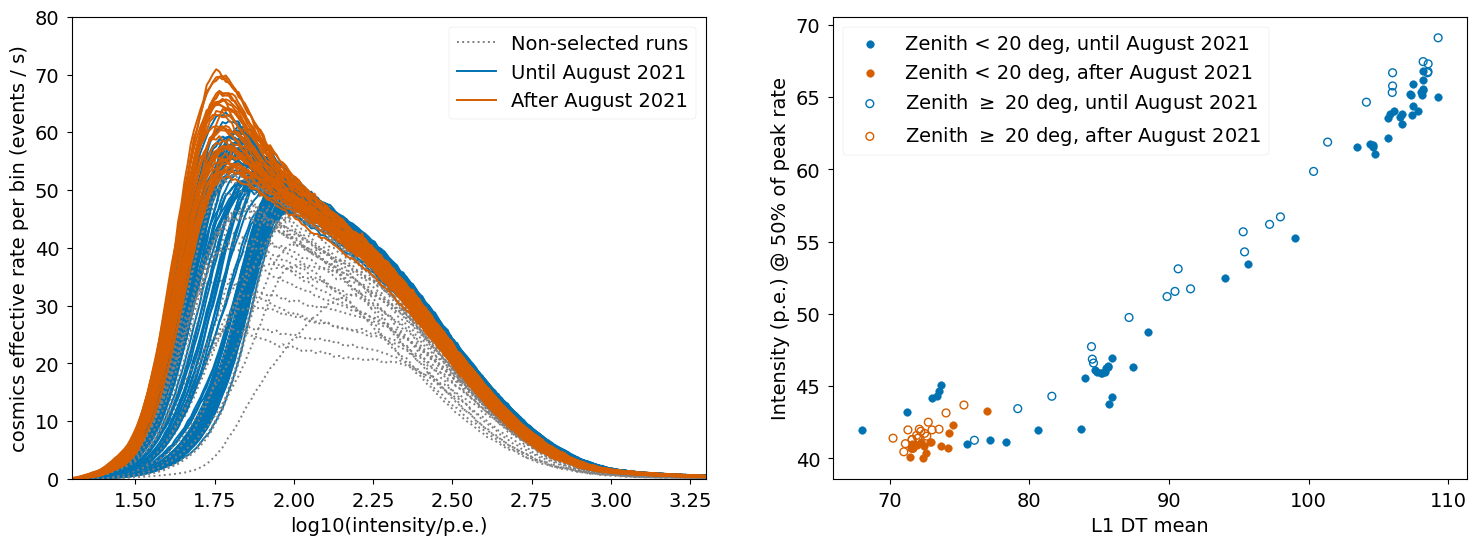

[2913 2914 2929 2930 2931 2932 2933 2934 2949 2950 2952 2953 2954 2955
 2956 2957 2958 2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977
 2988 2989 2990 2991 2992 3004 3005 3006 3007 3008 3093 3094 3095 3096
 3231 3232 3243 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3318
 3319 3320 3321 3328 3329 3330 3338 3339 3340 3355 3356 3373 3598 3599
 3600 3601 3615 3631 3632 3633 3634 3635 3672 3673 3674 3675 3676 3677
 3678 3679 3706 3707 3708 3954 3955 3956 3973 3974 3975 4027 4028 4029
 4067 4068 4086 4087 6045 6073 6148 6193 6194 6195 6242 6281 6282 6303
 6304 6324 6872 6873 6874 6875 6892 6893 6894 6895 7086 7097 7098 7099
 7133 7136 7161 7195 7196 7197 7198 7199 7200 7227 7228 7231 7232 7233
 7253 7254 7255 7256 7274 7275 7276 7277]
teff = 42.64 h


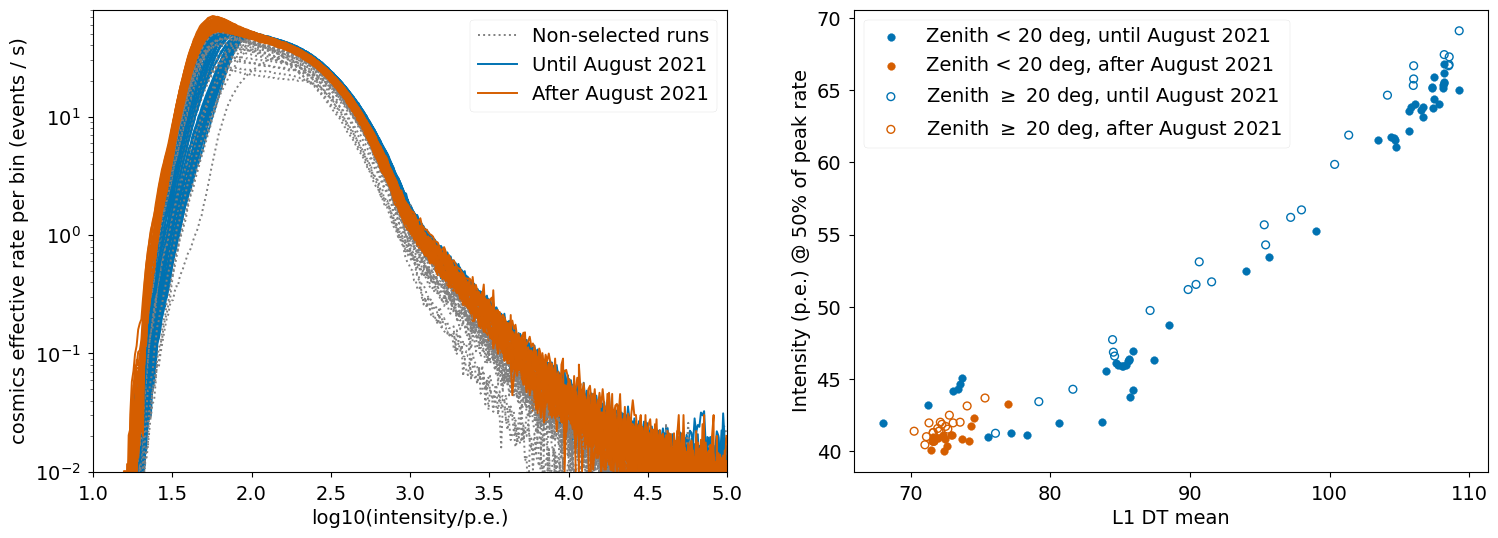

[2913 2914 2929 2930 2931 2932 2933 2934 2949 2950 2952 2953 2954 2955
 2956 2957 2958 2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977
 2988 2989 2990 2991 2992 3004 3005 3006 3007 3008 3093 3094 3095 3096
 3231 3232 3243 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3318
 3319 3320 3321 3328 3329 3330 3338 3339 3340 3355 3356 3373 3598 3599
 3600 3601 3615 3631 3632 3633 3634 3635 3672 3673 3674 3675 3676 3677
 3678 3679 3706 3707 3708 3954 3955 3956 3973 3974 3975 4027 4028 4029
 4067 4068 4086 4087 6045 6073 6148 6193 6194 6195 6242 6281 6282 6303
 6304 6324 6872 6873 6874 6875 6892 6893 6894 6895 7086 7097 7098 7099
 7133 7136 7161 7195 7196 7197 7198 7199 7200 7227 7228 7231 7232 7233
 7253 7254 7255 7256 7274 7275 7276 7277]
teff = 42.64 h


In [96]:
post_eruption_only = False

# for min, max, islog in zip([0, 1.65, 1.77, 0, 0], 
#                            [1.65, 1.77, 100, 100, 100],

#exclude_for_tests = [2929, 2930, 2931, 2932, 2933, 2934]

#exclude_for_tests = run_number[run_number<6500] # show only post-volcano
#exclude_for_tests = run_number[run_number>6500] # show only pre-volcano
exclude_for_tests = []

#zenith_range = [20, 35]
zenith_range = [0, 90]

color_selected = cb_colors[0]
color_rejected = 'grey'
color_selected_gt6000 = cb_colors[2]

for min, max, islog in zip([0, np.log10(50), np.log10(60), 0, 0], 
                           [np.log10(50), np.log10(60), 100, 100, 100],

                           [False, False, False, False, True]):

    if max - min < 99:
        # plt.figure(figsize=(16,8))
        plt.figure(figsize=(9,6))
    else:
        fig = plt.figure(figsize=(18,6))
        fig.add_subplot(1, 2, 1)

    runlist = []
    sumtime = 0
    
    legend_is_ready = [False, False, False] # for each type (& color) of runs 
    
    for i, run in enumerate(run_number):
        
        if post_eruption_only and (run < 6000):
            continue
        
        color = color_selected
        draw_legend = True

        if run in run_number[runselection] and run < 6000:
            legend_text = "Until August 2021"
            if legend_is_ready[0]:
                draw_legend = False
            else:
                legend_is_ready[0] = True

        elif run in run_number[runselection] and run > 6000:
            color = color_selected_gt6000
            legend_text = "After August 2021"
            if legend_is_ready[1]:
                draw_legend = False
            else:
                legend_is_ready[1] = True
                
        else:
            #continue
            color = color_rejected
            
            legend_text = "Non-selected runs"
            if legend_is_ready[2]:
                draw_legend = False
            else:
                legend_is_ready[2] = True

            
        if run in exclude_for_tests:
            continue
            
        if zenith[i] < zenith_range[0]:
            continue
            
        if zenith[i] > zenith_range[1]:
            continue
        
# Cut in l1_dt_std does not seem to improve spectra at all:
#         if run in l1_run:
#             index = np.where(l1_run==run)[0][0]
#             if l1_dt_std[index] > 1:
#                 continue
        
        time = eff_time_per_run[i]

        if run_intensity_50[i] < min:
            continue
        
        if run_intensity_50[i] > max:
            continue
            
        runlist.append(run)
        log10intensity = 0.5*(bins_intensity[1:]+bins_intensity[:-1])
        
        if run in run_number[runselection]:
            if draw_legend:
                plt.plot(log10intensity, num_evts[i,:] / time, color=color, label=legend_text)            
            else:
                plt.plot(log10intensity, num_evts[i,:] / time, color=color)
        else:
            if draw_legend:
                plt.plot(log10intensity, num_evts[i,:] / time, ':', color=color, label = legend_text)
            else:
                plt.plot(log10intensity, num_evts[i,:] / time, ':', color=color)
            

        sumtime += time

    # plt.grid()
    plt.xlim(1.3, 3.3)
    plt.ylim(0, 80)
    if (islog):
        plt.ylim(1e-2, 80)
        plt.yscale('log')
        plt.xlim(1, 5)

    plt.legend(fontsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('log10(intensity/p.e.)', fontsize=14)
    plt.ylabel('cosmics effective rate per bin (events / s)', fontsize=14)
    
    if max - min > 99:
        fig.add_subplot(1, 2, 2)
        plt.scatter(l1_dt_mean[runselection & (zenith<20) & (run_number<6000)], 
                    10**run_intensity_50[runselection & (zenith<20) & (run_number<6000)],
                    color=cb_colors[0],
                    label='Zenith < 20 deg, until August 2021')
        
        plt.scatter(l1_dt_mean[runselection & (zenith<20) & (run_number>6000)], 
                    10**run_intensity_50[runselection & (zenith<20) & (run_number>6000)],
                    color=cb_colors[2],
                    label='Zenith < 20 deg, after August 2021')
        
        plt.scatter(l1_dt_mean[runselection & (zenith>=20) & (run_number<6000)], 
                    10**run_intensity_50[runselection & (zenith>=20) & (run_number<6000)],
                    facecolors='none', edgecolors=cb_colors[0],
                    linewidths=1,
                    label='Zenith $\geq$ 20 deg, until August 2021')
        
        plt.scatter(l1_dt_mean[runselection & (zenith>=20) & (run_number>6000)], 
                    10**run_intensity_50[runselection & (zenith>=20) & (run_number>6000)],
                    facecolors='none', edgecolors=cb_colors[2],
                    label='Zenith $\geq$ 20 deg, after August 2021',
                    linewidths=1)

        plt.xlabel('L1 DT mean', fontsize=14)
        plt.ylabel('Intensity (p.e.) @ 50% of peak rate', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=14)
    
    
    plt.show()
    print(np.array(runlist))
    print (f'teff = {sumtime/3600.:.2f} h')

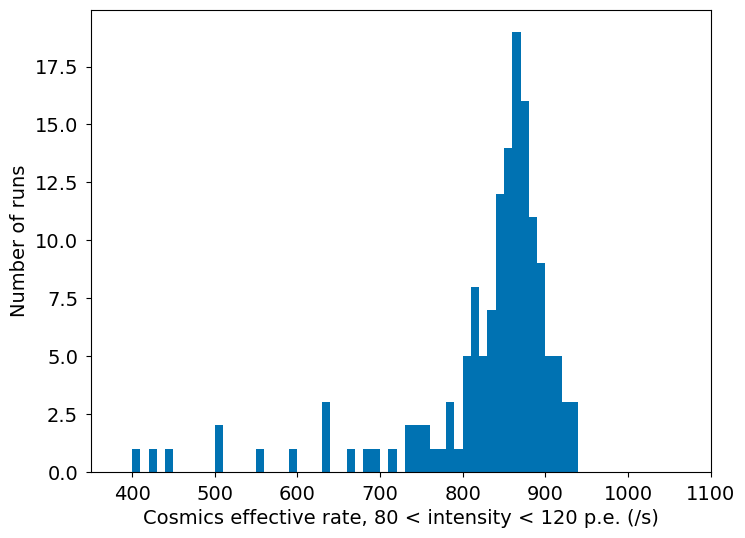

array([2913, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 3678, 3679, 3954,
       3955, 3956, 3973, 3974, 3975, 4027, 4028, 4029, 6148, 6193, 6194,
       6195, 6242, 7086, 7198])

In [97]:
plt.figure(figsize=(8, 6))
plt.hist(cosmics_per_run_i80to120/eff_time_per_run, bins=120, range=(0,1200))
plt.xlabel('Cosmics effective rate, 80 < intensity < 120 p.e. (/s)', fontsize=14)
plt.ylabel('Number of runs', fontsize=14)
plt.xlim(350, 1100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Runs with too low R_80-120:
run_number[(cosmics_per_run_i80to120/eff_time_per_run<800)]

In [98]:
#runselection = runselection_except_pixrate_cuts
runselection = runselection_final

In [99]:
runselection.sum()

117

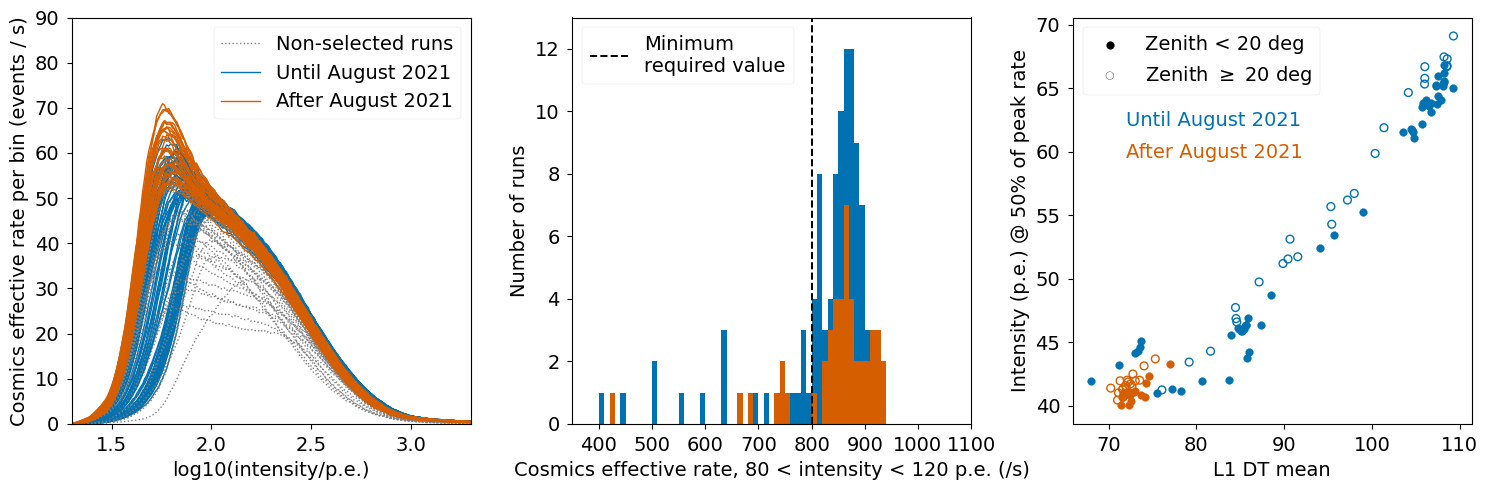

In [100]:
# Plot for the performance paper

#fig = plt.figure(figsize=(18,6))

fig = plt.figure(figsize=(15,5))
fig.add_subplot(1, 3, 1)

ratedata = [[], [], [], []]

legend_is_ready = [False, False, False] # for each type (& color) of runs 

for i, run in enumerate(run_number):

    color = color_selected
    draw_legend = True

    if run in run_number[runselection] and run < 6000:
        legend_text = "Until August 2021"
        if legend_is_ready[0]:
            draw_legend = False
        else:
            legend_is_ready[0] = True

    elif run in run_number[runselection] and run > 6000:
        color = color_selected_gt6000
        legend_text = "After August 2021"
        if legend_is_ready[1]:
            draw_legend = False
        else:
            legend_is_ready[1] = True

    else:
        color = color_rejected

        legend_text = "Non-selected runs"
        if legend_is_ready[2]:
            draw_legend = False
        else:
            legend_is_ready[2] = True

    time = eff_time_per_run[i]
    log10intensity = 0.5*(bins_intensity[1:]+bins_intensity[:-1])

    if run in run_number[runselection]:
        if draw_legend:
            plt.plot(log10intensity, num_evts[i,:] / time, color=color, linewidth=1, label=legend_text)            
        else:
            plt.plot(log10intensity, num_evts[i,:] / time, color=color, linewidth=1)
    else:
        if draw_legend:
            plt.plot(log10intensity, num_evts[i,:] / time, ':', color=color, linewidth=1, label = legend_text)
        else:
            plt.plot(log10intensity, num_evts[i,:] / time, ':', color=color, linewidth=1)

    ratedata[0] = np.append(ratedata[0], log10intensity)
    ratedata[1] = np.append(ratedata[1], num_evts[i,:]/time)
    ratedata[2] = np.append(ratedata[2], run*np.ones(len(log10intensity)))
    ratedata[3] = np.append(ratedata[3], (run in run_number[runselection])*np.ones(len(log10intensity)))

np.savetxt("Intensity_spectra.csv", 
           ratedata,
           fmt='%.5f', delimiter=',',
           header = 'Log10_intensity Rate RunNumber GoodRun')



plt.xlim(1.3, 3.3)
plt.locator_params(axis='x', nbins=6)
plt.ylim(0, 90)
plt.legend(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('log10(intensity/p.e.)', fontsize=14)
plt.ylabel('Cosmics effective rate per bin (events / s)', fontsize=14)




fig.add_subplot(1, 3, 2)
plt.hist((cosmics_per_run_i80to120/eff_time_per_run)[run_number<6000], 
         bins=120, range=(0,1200), color=cb_colors[0])
plt.hist((cosmics_per_run_i80to120/eff_time_per_run)[run_number>6000], 
         bins=120, range=(0,1200), color=cb_colors[2])

plt.plot([800, 800], [0, 13], color='black', linestyle='dashed',
        label='Minimum\nrequired value')

plt.xlabel('Cosmics effective rate, 80 < intensity < 120 p.e. (/s)', fontsize=14)
plt.ylabel('Number of runs', fontsize=14)
plt.xlim(350, 1100)
plt.ylim(0, 13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

np.savetxt("R_80_120.csv", 
           [cosmics_per_run_i80to120/eff_time_per_run, run_number],
           fmt='%.5f', delimiter=',',
           header = 'R_80_120 RunNumber')


fig.add_subplot(1, 3, 3)
plt.scatter(l1_dt_mean[runselection & (zenith<20) & (run_number<6000)], 
            10**run_intensity_50[runselection & (zenith<20) & (run_number<6000)],
            color=cb_colors[0])

plt.scatter([], [], color='black', label='Zenith < 20 deg')
plt.scatter([], [], facecolors='none', edgecolors='black', label='Zenith $\geq$ 20 deg')


plt.scatter(l1_dt_mean[runselection & (zenith<20) & (run_number>6000)], 
            10**run_intensity_50[runselection & (zenith<20) & (run_number>6000)],
            color=cb_colors[2])

plt.scatter(l1_dt_mean[runselection & (zenith>=20) & (run_number<6000)], 
            10**run_intensity_50[runselection & (zenith>=20) & (run_number<6000)],
            facecolors='none', edgecolors=cb_colors[0],
            linewidths=1)

plt.scatter(l1_dt_mean[runselection & (zenith>=20) & (run_number>6000)], 
            10**run_intensity_50[runselection & (zenith>=20) & (run_number>6000)],
            facecolors='none', edgecolors=cb_colors[2],
            linewidths=1)


np.savetxt("trigger_threshold.csv", 
           [l1_dt_mean[runselection], 10**run_intensity_50[runselection], 
            run_number[runselection], zenith[runselection]],
           fmt='%.5f', delimiter=',',
           header = 'L1_DT_mean Intensity50 RunNumber Zenith')


plt.xlabel('L1 DT mean', fontsize=14)
plt.ylabel('Intensity (p.e.) @ 50% of peak rate', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)


plt.text(72, 62, 'Until August 2021', color=cb_colors[0], fontsize=14)
plt.text(72, 59.5, 'After August 2021', color=cb_colors[2], fontsize=14)


plt.tight_layout()
plt.savefig("intensity_spectra.pdf", bbox_inches='tight')

plt.show()


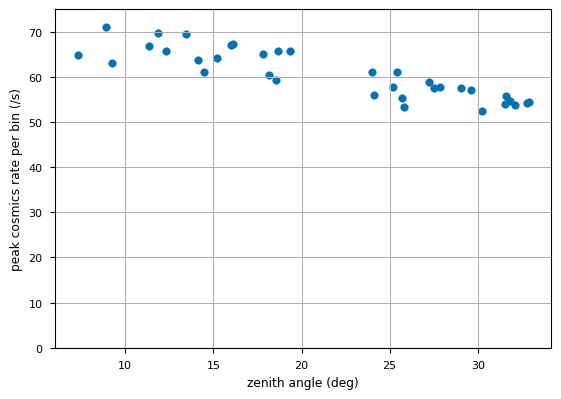

In [101]:
# peak rate vs zenith only for post-eruption data
plt.scatter(zenith[runselection & (run_number>6000)], intensity_peak_rate[runselection & (run_number>6000)])
plt.ylim(0, 75)
plt.grid()
plt.xlabel('zenith angle (deg)')
plt.ylabel('peak cosmics rate per bin (/s)')
plt.show()

In [102]:
table1.columns

Index(['obs_id', 'event_id', 'log_intensity', 'x', 'y', 'alt_tel', 'az_tel',
       'dragon_time', 'event_type', 'delta_t', 'log_reco_energy', 'reco_src_x',
       'reco_src_y', 'gammaness', 'src_x', 'src_y'],
      dtype='object')

In [103]:
# Check radial image centroid distribution for low intensity events, to study effect of stars etc:

mask = cosmics1 & soft_gammaness_cut & (table1['log_intensity']<np.log10(100.))

#mask = cosmics1 & (table1['log_intensity']<np.log10(100.))
r2 = table1['x']**2 + table1['y']**2

num_evts_r2, _, bins_r2 = np.histogram2d(run_order[mask], r2[mask],
                                         bins=(1+run_order.max(), 75),
                                         range=((-0.5, run_order.max()+0.5), (0, 1.5)))

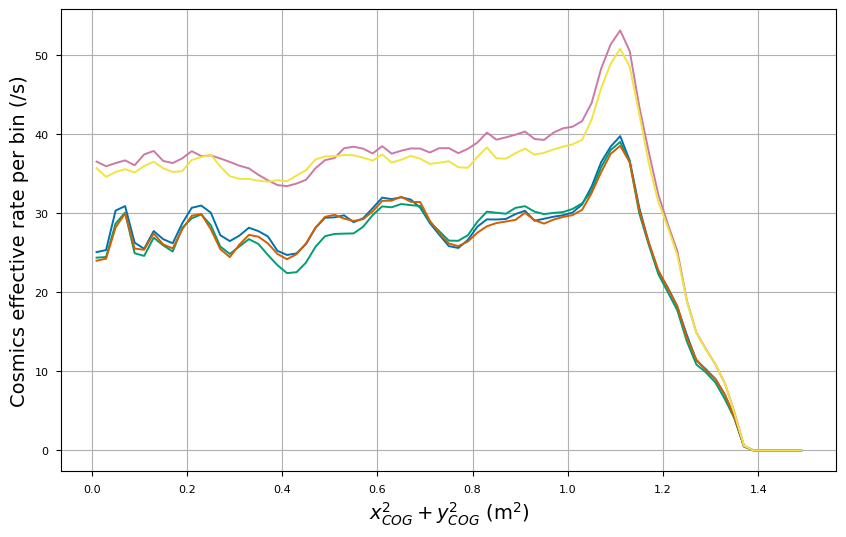

In [104]:
min = 0
max = 1e6 # 42

runs_to_test = [2931,2932,2933, 6872, 6873]

plt.figure(figsize=(10,6))

xr2 = 0.5*(bins_r2[1:]+bins_r2[:-1])

for i, run in enumerate(run_number):
        
    if run not in run_number[runselection]:
        continue

    if run not in runs_to_test:
        continue
        
    time = eff_time_per_run[i]

    if min > 0:
        if run_intensity_50[i] < np.log10(min):
            continue
        
    if run_intensity_50[i] > np.log10(max):
        continue

    plt.plot(xr2, num_evts_r2[i,:] / time)
    
plt.xlabel('$x_{COG}^{2} + y_{COG}^{2}$ (m$^2$)', fontsize=14)
plt.ylabel('Cosmics effective rate per bin (/s)', fontsize=14)

plt.grid()
plt.show()

In [105]:
# Now create an event-wise parameter which is event_id / max_event_id_in_run  so that we can do plots 
# separately for different parts of a run

run_fraction = np.zeros_like(obs_id, dtype='float32')
event_id = table1['event_id'].to_numpy()

print(run_changes)

[        0   4592792   9460180  14290877  19468037  24613269  29625046
  34772836  39880590  44790257  50670235  54747349  58479777  62788231
  67877687  72590801  75712407  78917574  83940304  89093623  94358893
  99740347 105243916 110795060 116345807 121928803 127408658 132685495
 137947372 143726755 149269243 154690216 160106268 165451193 171188914
 176516337 181998668 187609628 193070257 198394027 204050686 213012352
 218822381 223432840 227816075 232322517 237316096 242363816 247460660
 252691815 257706404 262657293 267427762 272036214 276576651 279851659
 284315205 289059444 293661667 298398080 303101352 307647386 312130338
 317037862 321479126 325560411 330223481 334892707 339695665 344020735
 348499368 353082362 357113476 363020995 365219704 369302750 371626816
 375638845 379257534 383440121 387925436 392235626 396088184 400179275
 404407505 408548983 412588398 416957882 421170241 425688863 430590993
 434472035 437888677 440054947 444431637 448202327 452615761 455722964
 45929

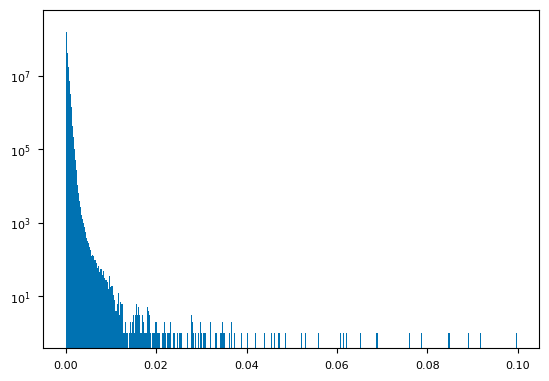

In [106]:
dragon_dt = np.diff(table1['dragon_time'])
dragon_dt = np.insert(dragon_dt, 0, 0.)

plt.hist(dragon_dt[(dragon_dt<0.1) & (dragon_dt>0)], bins=1000)
plt.yscale('log')
plt.show()

In [107]:
for n1, n2 in zip(run_changes[:-1], run_changes[1:]):
    run_fraction[n1:n2] = event_id[n1:n2]/event_id[n2-1]

print(run_fraction.min(), run_fraction.max(), run_fraction.shape)

8.729369e-08 1.0000001 (676198976,)


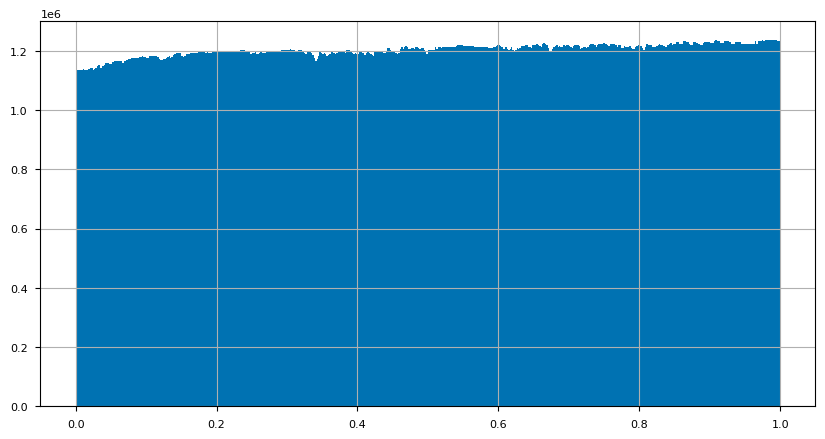

In [108]:
plt.figure(figsize=(10,5))
plt.hist(run_fraction[cosmics1 & soft_gammaness_cut], bins=500)
plt.grid()
plt.show()

In [109]:
# Use wider bins than in previous, run-wise plots, for the sake of statistics:
bin_width_ratio = 5

num_evts_per_run_fraction, _, bins_intensity_coarse = np.histogram2d(run_order[cosmics1 & soft_gammaness_cut] +
                                                              run_fraction[cosmics1 & soft_gammaness_cut], 
                                                              table1['log_intensity'][cosmics1 & soft_gammaness_cut],
                                                              bins=(20*(run_order.max()+1), int(500/bin_width_ratio)),
                                                              range=((0, run_order.max()+1), (0, 5)))

In [110]:
drmask = (dragon_dt<0.1) & (dragon_dt>0)
dragon_dt[drmask].sum()/3600.

44.6591740689675

In [111]:
elapsed_time_per_run.sum()/3600.

44.62455311755339

In [112]:
elapsed_time_per_run_fraction, _ = np.histogram((run_order+run_fraction)[drmask], weights=dragon_dt[drmask],
                                                bins=20*(run_order.max()+1),
                                                range=(0, run_order.max()+1))

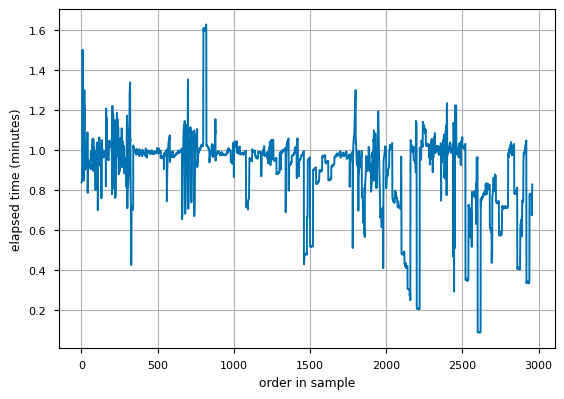

In [113]:
plt.plot(elapsed_time_per_run_fraction/60.)
plt.ylabel('elapsed time (minutes)')
plt.xlabel('order in sample')
plt.grid()
plt.show()

In [114]:
run_number[runselection] # & (run_intensity_50<np.log10(42))]

array([2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968,
       2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
       2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095,
       3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
       3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338,
       3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601, 3615, 3632,
       3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706, 3707,
       3708, 4067, 4068, 4086, 4087, 6045, 6073, 6304, 6872, 6873, 6874,
       6875, 6892, 6893, 6894, 6895, 7097, 7098, 7099, 7133, 7136, 7161,
       7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231, 7232, 7233, 7253,
       7254, 7255, 7256, 7274, 7275, 7276, 7277])

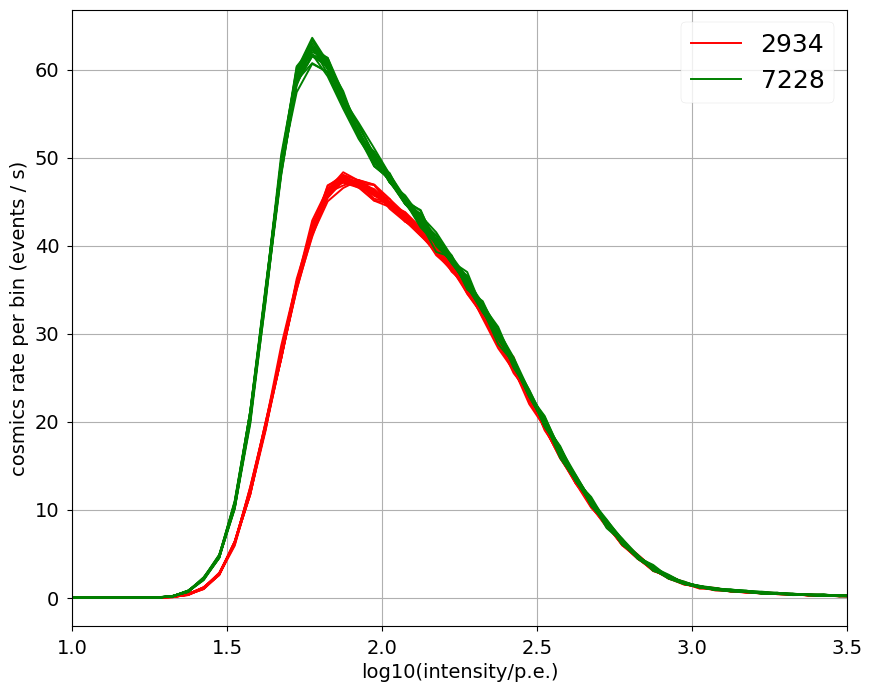

In [115]:
log10intensity = 0.5*(bins_intensity_coarse[1:]+bins_intensity_coarse[:-1])

linecolors = ['red']

#runs_to_plot = [2929] # one outlier
#runs_to_plot = [2932] # horrible variations!
#runs_to_plot = [2950] # two outliers
#runs_to_plot = [2988] # some apparent threshold variations

# Very suspicious behaviour:
#runs_to_plot = [3005]
#runs_to_plot = [3006]
#runs_to_plot = [3007]
#runs_to_plot = [3008]

#runs_to_plot = [6045] # perfect!
#runs_to_plot = [6073] # meh... onesub-period low in the middle
#runs_to_plot = [6872, 6873, 6874, 6875] # perfect!

#runs_to_plot = [6892] # ok
#runs_to_plot = [6893] # so-so
#runs_to_plot = [6894] # quite nice!
#runs_to_plot = [6895] # quite nice!


#runs_to_plot = [7097] # perfect
#runs_to_plot = [7098] # perfect
#runs_to_plot = [7099] # very good   # 7097-7099 show some variability in peak, perhaps zenith angle

#runs_to_plot = [7133] #perfect

#runs_to_plot = [7195] # ugly
#runs_to_plot = [7197] # perfect

#runs_to_plot = [7200] # very ugly
#runs_to_plot = [7227] # perfect
#runs_to_plot = [7228] # perfect
#runs_to_plot = [7231] # so-so
#runs_to_plot = [7232] # quite good
#runs_to_plot = [7233] #  very good
#runs_to_plot = [7253] # very good
#runs_to_plot = [7254] # very good
#runs_to_plot = [7255] # very good
#runs_to_plot = [7256] # very good except for last one (too short?) Weird!!
#runs_to_plot = [7274] # so-so, oneclear outlier in the middle
#runs_to_plot = [7275] # quite good


#runs_to_plot = run_number[runselection & (run_intensity_50 < np.log10(50))]

# Low zenith, comparison of good and bad-threshold runs:
#runs_to_plot = [2931,2932,2933, 6872, 6873]
#runs_to_plot = [2932, 6872]
#linecolors = ['red', 'green']

runs_to_plot = [2934, 7228]
linecolors = ['red', 'green']


#runs_to_plot = [2929,2930,2934, 7227, 7228]
#linecolors = ['red', 'red', 'red', 'green', 'green']

plt.figure(figsize=(10,8))

for color, run_to_plot in zip(linecolors, runs_to_plot):

    plot_run_index = np.where(run_number==run_to_plot)[0][0]

    for i in range(20):
            clabel = None
            if i == 0:
                clabel = f'{run_to_plot}'
            plt.plot(log10intensity, 
                     num_evts_per_run_fraction[20*plot_run_index+i,:] / 
                     elapsed_time_per_run_fraction[20*plot_run_index+i] / bin_width_ratio,
                     color=color, label=clabel) # label=f'{i}', 

plt.legend(fontsize=18)
plt.grid()
plt.xlim(1, 3.5)
#plt.yscale('log')
plt.xlabel('log10(intensity/p.e.)', fontsize=14)
plt.ylabel('cosmics rate per bin (events / s)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()


In [116]:
bin100 = np.where(log10intensity>2)[0][0]
mean_rate_at_100 = np.zeros_like(run_number, dtype='float32')
std_rate_at_100 = np.zeros_like(mean_rate_at_100)

for run_index in range(len(run_number)):
    for i in range(20):
        r_at_100 = (num_evts_per_run_fraction[20*run_index:20*run_index+20,bin100] / 
                    elapsed_time_per_run_fraction[20*run_index:20*run_index+20] /
                    bin_width_ratio) 

        mean_rate_at_100[run_index] = np.mean(r_at_100)
        std_rate_at_100[run_index] = np.std(r_at_100)

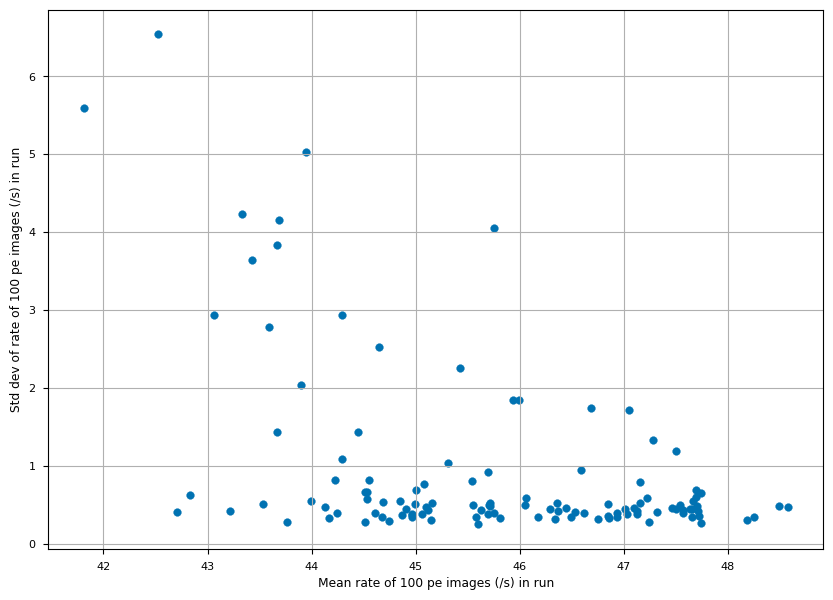

In [117]:
plt.figure(figsize=(10,7))
plt.scatter(mean_rate_at_100[runselection], std_rate_at_100[runselection])
plt.grid()
plt.xlabel('Mean rate of 100 pe images (/s) in run')
plt.ylabel('Std dev of rate of 100 pe images (/s) in run')
plt.show()

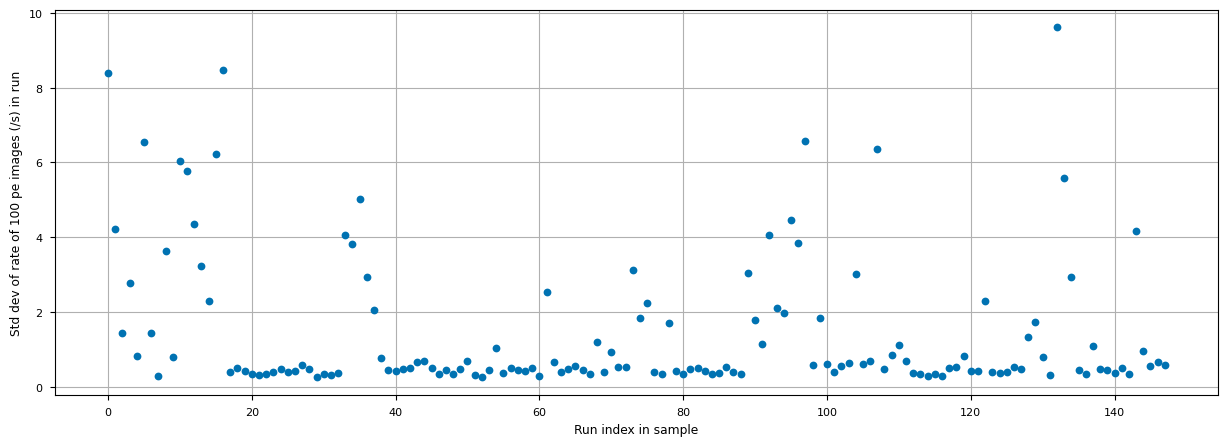

In [118]:
plt.figure(figsize=(15,5))
plt.plot(std_rate_at_100, 'o')
plt.grid()
plt.xlabel('Run index in sample')
plt.ylabel('Std dev of rate of 100 pe images (/s) in run')
plt.show()

In [119]:
print((runselection & (std_rate_at_100>1)).sum(), 'runs')
print()
print(eff_time_per_run[runselection & (std_rate_at_100>1)].sum()/3600., 'h')

run_number[runselection & (std_rate_at_100>1)]

24 runs

6.52312855137751 h


array([2914, 2929, 2930, 2932, 2933, 2949, 3004, 3005, 3006, 3007, 3008,
       3279, 3330, 3598, 3632, 3633, 3672, 4068, 7161, 7195, 7199, 7200,
       7231, 7256])

In [120]:
dt_evts, _, dt_bins = np.histogram2d(run_order, table1['delta_t'], 
                                     bins=(run_order[-1]+1,5000), 
                                     range=((-0.5, run_order[-1]+0.5), (0, 0.1)))

In [121]:
dt_dl2_evts, _, dt_bins = np.histogram2d(run_order, dragon_dt, 
                                     bins=(run_order[-1]+1,5000), 
                                     range=((-0.5, run_order[-1]+0.5), (0, 0.1)))

2931 8280.2 4293.5
6872 7764.8 4811.1


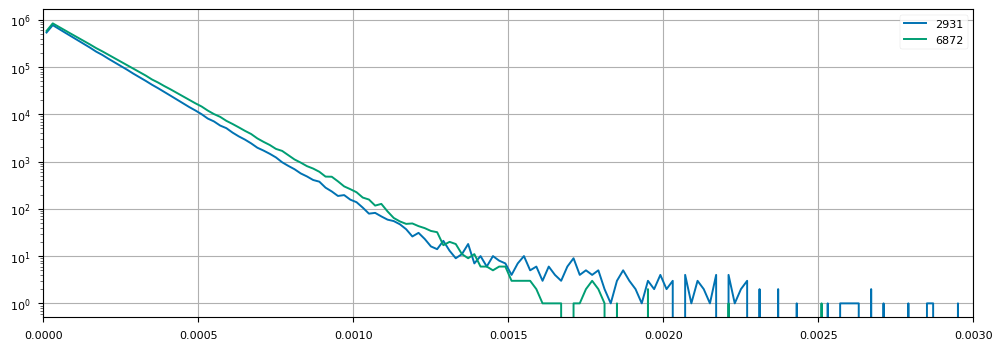

2931 8280.2           4293.5           0.936
6872 7764.8           4811.1           0.938


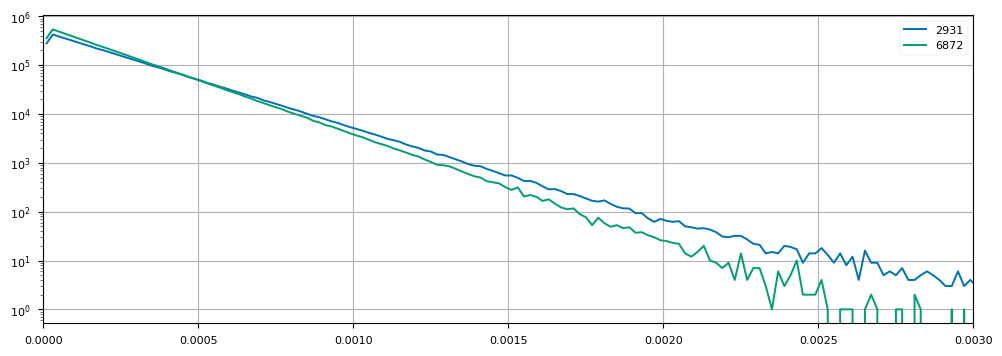

In [122]:
#showruns = [2931,2932,2933, 6872, 6873]
# showruns = [2934, 7228]
showruns = [2931, 6872]

plt.figure(figsize=(12,4))
for rr in showruns:
    jj = np.where(run_number==rr)[0][0]
    plt.plot(0.5*(dt_bins[:-1]+dt_bins[1:]), dt_evts[jj,:], label=f'{rr}')
    print(f'{rr} {(triggered_cosmics_per_run/elapsed_time_per_run)[jj]:.1f} {(cosmics_per_run/elapsed_time_per_run)[jj]:.1f}')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlim(0, 0.003)
plt.show()

plt.figure(figsize=(12,4))
for rr in showruns:
    jj = np.where(run_number==rr)[0][0]
    plt.plot(0.5*(dt_bins[:-1]+dt_bins[1:]), dt_dl2_evts[jj,:], label=f'{rr}')
    print(f'{rr} {(triggered_cosmics_per_run/elapsed_time_per_run)[jj]:.1f} \
          {(cosmics_per_run/elapsed_time_per_run)[jj]:.1f} \
          {eff_time_per_run[np.where(run_number==rr)[0][0]] / elapsed_time_per_run[np.where(run_number==rr)[0][0]]:.3f}')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlim(0, 0.003)
plt.show()